In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'diffusion_md',
    'features_clin' : ['CAP','TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'balance_data'  : False,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
    'exclude'       : ['t1t2'],
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_e_CAP_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2918641, 833)
(2918641, 8)
validation
(345044, 833)
(345044, 8)
test
(360444, 833)
(360444, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 833)]             0         


 dense (Dense)               (None, 2048)              1708032   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4496264 (17.15 MB)


Trainable params: 4496264 (17.15 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/30 [>.............................] - ETA: 4:42 - loss: 2.5560 - STD: 0.1013 - MAE: 0.2208

 2/30 [=>............................] - ETA: 10s - loss: 2.4043 - STD: 0.0780 - MAE: 0.2205 

 3/30 [==>...........................] - ETA: 10s - loss: 2.3069 - STD: 0.0593 - MAE: 0.2201

 4/30 [===>..........................] - ETA: 26s - loss: 2.2924 - STD: 0.0494 - MAE: 0.2195

 5/30 [====>.........................] - ETA: 21s - loss: 2.2377 - STD: 0.0492 - MAE: 0.2188

 6/30 [=====>........................] - ETA: 18s - loss: 2.2096 - STD: 0.0530 - MAE: 0.2180

 7/30 [======>.......................] - ETA: 16s - loss: 2.1938 - STD: 0.0572 - MAE: 0.2174

 8/30 [=======>......................] - ETA: 14s - loss: 2.1832 - STD: 0.0603 - MAE: 0.2170

 9/30 [========>.....................] - ETA: 13s - loss: 2.1742 - STD: 0.0619 - MAE: 0.2167

10/30 [=========>....................] - ETA: 11s - loss: 2.1654 - STD: 0.0621 - MAE: 0.2165

11/30 [==========>...................] - ETA: 10s - loss: 2.1573 - STD: 0.0613 - MAE: 0.2165

12/30 [===========>..................] - ETA: 10s - loss: 2.1497 - STD: 0.0599 - MAE: 0.2164

13/30 [============>.................] - ETA: 9s - loss: 2.1428 - STD: 0.0580 - MAE: 0.2165 

14/30 [=============>................] - ETA: 8s - loss: 2.1365 - STD: 0.0560 - MAE: 0.2165

15/30 [==============>...............] - ETA: 7s - loss: 2.1308 - STD: 0.0539 - MAE: 0.2166

16/30 [===============>..............] - ETA: 7s - loss: 2.1258 - STD: 0.0519 - MAE: 0.2166

17/30 [================>.............] - ETA: 6s - loss: 2.1217 - STD: 0.0502 - MAE: 0.2167

18/30 [=================>............] - ETA: 5s - loss: 2.1181 - STD: 0.0488 - MAE: 0.2167

19/30 [==================>...........] - ETA: 5s - loss: 2.1151 - STD: 0.0477 - MAE: 0.2168

20/30 [===================>..........] - ETA: 4s - loss: 2.1125 - STD: 0.0467 - MAE: 0.2168

21/30 [====================>.........] - ETA: 4s - loss: 2.1102 - STD: 0.0460 - MAE: 0.2168

22/30 [=====================>........] - ETA: 3s - loss: 2.1079 - STD: 0.0453 - MAE: 0.2168

23/30 [======================>.......] - ETA: 3s - loss: 2.1057 - STD: 0.0446 - MAE: 0.2168

24/30 [=======================>......] - ETA: 2s - loss: 2.1037 - STD: 0.0440 - MAE: 0.2168

25/30 [========================>.....] - ETA: 2s - loss: 2.1017 - STD: 0.0435 - MAE: 0.2168

26/30 [=========================>....] - ETA: 1s - loss: 2.0998 - STD: 0.0430 - MAE: 0.2169

27/30 [==========================>...] - ETA: 1s - loss: 2.0980 - STD: 0.0425 - MAE: 0.2169

28/30 [===========================>..] - ETA: 0s - loss: 2.0963 - STD: 0.0422 - MAE: 0.2168

29/30 [============================>.] - ETA: 0s - loss: 2.0948 - STD: 0.0419 - MAE: 0.2168

30/30 [==============================] - ETA: 0s - loss: 2.0934 - STD: 0.0417 - MAE: 0.2168

30/30 [==============================] - 26s 549ms/step - loss: 2.0934 - STD: 0.0417 - MAE: 0.2168 - val_loss: 2.0560 - val_STD: 0.0365 - val_MAE: 0.2165


Epoch 2/10000


 1/30 [>.............................] - ETA: 14s - loss: 2.0536 - STD: 0.0365 - MAE: 0.2165

 2/30 [=>............................] - ETA: 10s - loss: 2.0545 - STD: 0.0370 - MAE: 0.2165

 3/30 [==>...........................] - ETA: 10s - loss: 2.0552 - STD: 0.0373 - MAE: 0.2165

 4/30 [===>..........................] - ETA: 10s - loss: 2.0554 - STD: 0.0375 - MAE: 0.2165

 5/30 [====>.........................] - ETA: 9s - loss: 2.0552 - STD: 0.0375 - MAE: 0.2165 

 6/30 [=====>........................] - ETA: 9s - loss: 2.0550 - STD: 0.0374 - MAE: 0.2165

 7/30 [======>.......................] - ETA: 8s - loss: 2.0548 - STD: 0.0371 - MAE: 0.2165

 8/30 [=======>......................] - ETA: 8s - loss: 2.0544 - STD: 0.0368 - MAE: 0.2165

 9/30 [========>.....................] - ETA: 8s - loss: 2.0540 - STD: 0.0363 - MAE: 0.2165

10/30 [=========>....................] - ETA: 7s - loss: 2.0538 - STD: 0.0359 - MAE: 0.2165

11/30 [==========>...................] - ETA: 7s - loss: 2.0537 - STD: 0.0354 - MAE: 0.2166

12/30 [===========>..................] - ETA: 6s - loss: 2.0536 - STD: 0.0350 - MAE: 0.2166

13/30 [============>.................] - ETA: 6s - loss: 2.0534 - STD: 0.0345 - MAE: 0.2166

14/30 [=============>................] - ETA: 6s - loss: 2.0533 - STD: 0.0341 - MAE: 0.2166

15/30 [==============>...............] - ETA: 5s - loss: 2.0533 - STD: 0.0338 - MAE: 0.2166

16/30 [===============>..............] - ETA: 5s - loss: 2.0533 - STD: 0.0335 - MAE: 0.2167

17/30 [================>.............] - ETA: 5s - loss: 2.0533 - STD: 0.0333 - MAE: 0.2167

18/30 [=================>............] - ETA: 4s - loss: 2.0532 - STD: 0.0331 - MAE: 0.2167

19/30 [==================>...........] - ETA: 4s - loss: 2.0532 - STD: 0.0329 - MAE: 0.2167

20/30 [===================>..........] - ETA: 3s - loss: 2.0531 - STD: 0.0328 - MAE: 0.2167

21/30 [====================>.........] - ETA: 3s - loss: 2.0530 - STD: 0.0327 - MAE: 0.2167

22/30 [=====================>........] - ETA: 3s - loss: 2.0529 - STD: 0.0327 - MAE: 0.2167

23/30 [======================>.......] - ETA: 2s - loss: 2.0528 - STD: 0.0326 - MAE: 0.2167

24/30 [=======================>......] - ETA: 2s - loss: 2.0528 - STD: 0.0326 - MAE: 0.2167

25/30 [========================>.....] - ETA: 1s - loss: 2.0528 - STD: 0.0327 - MAE: 0.2167

26/30 [=========================>....] - ETA: 1s - loss: 2.0527 - STD: 0.0327 - MAE: 0.2167

27/30 [==========================>...] - ETA: 1s - loss: 2.0527 - STD: 0.0327 - MAE: 0.2167

28/30 [===========================>..] - ETA: 0s - loss: 2.0527 - STD: 0.0328 - MAE: 0.2167

29/30 [============================>.] - ETA: 0s - loss: 2.0527 - STD: 0.0328 - MAE: 0.2167

30/30 [==============================] - ETA: 0s - loss: 2.0526 - STD: 0.0328 - MAE: 0.2167

30/30 [==============================] - 12s 407ms/step - loss: 2.0526 - STD: 0.0328 - MAE: 0.2167 - val_loss: 2.0526 - val_STD: 0.0327 - val_MAE: 0.2167


Epoch 3/10000


 1/30 [>.............................] - ETA: 17s - loss: 2.0532 - STD: 0.0327 - MAE: 0.2167

 2/30 [=>............................] - ETA: 10s - loss: 2.0525 - STD: 0.0325 - MAE: 0.2167

 3/30 [==>...........................] - ETA: 10s - loss: 2.0524 - STD: 0.0322 - MAE: 0.2167

 4/30 [===>..........................] - ETA: 10s - loss: 2.0521 - STD: 0.0320 - MAE: 0.2167

 5/30 [====>.........................] - ETA: 9s - loss: 2.0520 - STD: 0.0318 - MAE: 0.2168 

 6/30 [=====>........................] - ETA: 9s - loss: 2.0521 - STD: 0.0316 - MAE: 0.2168

 7/30 [======>.......................] - ETA: 8s - loss: 2.0521 - STD: 0.0314 - MAE: 0.2168

 8/30 [=======>......................] - ETA: 8s - loss: 2.0519 - STD: 0.0313 - MAE: 0.2168

 9/30 [========>.....................] - ETA: 8s - loss: 2.0519 - STD: 0.0312 - MAE: 0.2168

10/30 [=========>....................] - ETA: 7s - loss: 2.0519 - STD: 0.0311 - MAE: 0.2168

11/30 [==========>...................] - ETA: 6s - loss: 2.0518 - STD: 0.0311 - MAE: 0.2168

12/30 [===========>..................] - ETA: 6s - loss: 2.0518 - STD: 0.0311 - MAE: 0.2168

13/30 [============>.................] - ETA: 6s - loss: 2.0516 - STD: 0.0311 - MAE: 0.2168

14/30 [=============>................] - ETA: 5s - loss: 2.0515 - STD: 0.0311 - MAE: 0.2168

15/30 [==============>...............] - ETA: 5s - loss: 2.0515 - STD: 0.0311 - MAE: 0.2168

16/30 [===============>..............] - ETA: 5s - loss: 2.0514 - STD: 0.0312 - MAE: 0.2168

17/30 [================>.............] - ETA: 4s - loss: 2.0513 - STD: 0.0313 - MAE: 0.2168

18/30 [=================>............] - ETA: 4s - loss: 2.0513 - STD: 0.0314 - MAE: 0.2168

19/30 [==================>...........] - ETA: 4s - loss: 2.0512 - STD: 0.0314 - MAE: 0.2167

20/30 [===================>..........] - ETA: 3s - loss: 2.0511 - STD: 0.0315 - MAE: 0.2167

21/30 [====================>.........] - ETA: 3s - loss: 2.0510 - STD: 0.0315 - MAE: 0.2167

22/30 [=====================>........] - ETA: 2s - loss: 2.0509 - STD: 0.0316 - MAE: 0.2167

23/30 [======================>.......] - ETA: 2s - loss: 2.0508 - STD: 0.0316 - MAE: 0.2167

24/30 [=======================>......] - ETA: 2s - loss: 2.0506 - STD: 0.0316 - MAE: 0.2167

25/30 [========================>.....] - ETA: 1s - loss: 2.0504 - STD: 0.0316 - MAE: 0.2167

26/30 [=========================>....] - ETA: 1s - loss: 2.0503 - STD: 0.0316 - MAE: 0.2167

27/30 [==========================>...] - ETA: 1s - loss: 2.0501 - STD: 0.0316 - MAE: 0.2167

28/30 [===========================>..] - ETA: 0s - loss: 2.0499 - STD: 0.0316 - MAE: 0.2167

29/30 [============================>.] - ETA: 0s - loss: 2.0497 - STD: 0.0316 - MAE: 0.2167

30/30 [==============================] - ETA: 0s - loss: 2.0495 - STD: 0.0316 - MAE: 0.2167

30/30 [==============================] - 12s 409ms/step - loss: 2.0495 - STD: 0.0316 - MAE: 0.2167 - val_loss: 2.0422 - val_STD: 0.0314 - val_MAE: 0.2164


Epoch 4/10000


 1/30 [>.............................] - ETA: 14s - loss: 2.0412 - STD: 0.0311 - MAE: 0.2164

 2/30 [=>............................] - ETA: 10s - loss: 2.0401 - STD: 0.0311 - MAE: 0.2164

 3/30 [==>...........................] - ETA: 6s - loss: 2.0402 - STD: 0.0311 - MAE: 0.2164 

 4/30 [===>..........................] - ETA: 7s - loss: 2.0384 - STD: 0.0311 - MAE: 0.2163

 5/30 [====>.........................] - ETA: 7s - loss: 2.0368 - STD: 0.0311 - MAE: 0.2163

 6/30 [=====>........................] - ETA: 7s - loss: 2.0353 - STD: 0.0311 - MAE: 0.2162

 7/30 [======>.......................] - ETA: 7s - loss: 2.0337 - STD: 0.0312 - MAE: 0.2162

 8/30 [=======>......................] - ETA: 7s - loss: 2.0321 - STD: 0.0314 - MAE: 0.2161

 9/30 [========>.....................] - ETA: 7s - loss: 2.0301 - STD: 0.0315 - MAE: 0.2160

10/30 [=========>....................] - ETA: 7s - loss: 2.0280 - STD: 0.0317 - MAE: 0.2160

11/30 [==========>...................] - ETA: 6s - loss: 2.0257 - STD: 0.0318 - MAE: 0.2159

12/30 [===========>..................] - ETA: 6s - loss: 2.0233 - STD: 0.0320 - MAE: 0.2158

13/30 [============>.................] - ETA: 6s - loss: 2.0206 - STD: 0.0322 - MAE: 0.2157

14/30 [=============>................] - ETA: 5s - loss: 2.0177 - STD: 0.0324 - MAE: 0.2156

15/30 [==============>...............] - ETA: 5s - loss: 2.0143 - STD: 0.0327 - MAE: 0.2155

16/30 [===============>..............] - ETA: 5s - loss: 2.0108 - STD: 0.0331 - MAE: 0.2153

17/30 [================>.............] - ETA: 4s - loss: 2.0071 - STD: 0.0334 - MAE: 0.2152

18/30 [=================>............] - ETA: 4s - loss: 2.0031 - STD: 0.0341 - MAE: 0.2150

19/30 [==================>...........] - ETA: 4s - loss: 1.9987 - STD: 0.0347 - MAE: 0.2148

20/30 [===================>..........] - ETA: 3s - loss: 1.9943 - STD: 0.0354 - MAE: 0.2146

21/30 [====================>.........] - ETA: 3s - loss: 1.9896 - STD: 0.0363 - MAE: 0.2144

22/30 [=====================>........] - ETA: 2s - loss: 1.9851 - STD: 0.0371 - MAE: 0.2142

23/30 [======================>.......] - ETA: 2s - loss: 1.9803 - STD: 0.0382 - MAE: 0.2140

24/30 [=======================>......] - ETA: 2s - loss: 1.9752 - STD: 0.0393 - MAE: 0.2137

25/30 [========================>.....] - ETA: 1s - loss: 1.9705 - STD: 0.0403 - MAE: 0.2135

26/30 [=========================>....] - ETA: 1s - loss: 1.9655 - STD: 0.0415 - MAE: 0.2132

27/30 [==========================>...] - ETA: 1s - loss: 1.9603 - STD: 0.0427 - MAE: 0.2129

28/30 [===========================>..] - ETA: 0s - loss: 1.9555 - STD: 0.0437 - MAE: 0.2126

29/30 [============================>.] - ETA: 0s - loss: 1.9507 - STD: 0.0449 - MAE: 0.2124

30/30 [==============================] - ETA: 0s - loss: 1.9455 - STD: 0.0459 - MAE: 0.2121

30/30 [==============================] - 12s 409ms/step - loss: 1.9455 - STD: 0.0459 - MAE: 0.2121 - val_loss: 1.8202 - val_STD: 0.0777 - val_MAE: 0.2046


Epoch 5/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.7907 - STD: 0.0762 - MAE: 0.2041

 2/30 [=>............................] - ETA: 10s - loss: 1.7923 - STD: 0.0786 - MAE: 0.2038

 3/30 [==>...........................] - ETA: 10s - loss: 1.7931 - STD: 0.0781 - MAE: 0.2039

 4/30 [===>..........................] - ETA: 10s - loss: 1.7887 - STD: 0.0799 - MAE: 0.2035

 5/30 [====>.........................] - ETA: 9s - loss: 1.7822 - STD: 0.0810 - MAE: 0.2032 

 6/30 [=====>........................] - ETA: 9s - loss: 1.7794 - STD: 0.0817 - MAE: 0.2030

 7/30 [======>.......................] - ETA: 8s - loss: 1.7784 - STD: 0.0832 - MAE: 0.2027

 8/30 [=======>......................] - ETA: 8s - loss: 1.7744 - STD: 0.0838 - MAE: 0.2025

 9/30 [========>.....................] - ETA: 8s - loss: 1.7707 - STD: 0.0842 - MAE: 0.2024

10/30 [=========>....................] - ETA: 7s - loss: 1.7689 - STD: 0.0849 - MAE: 0.2022

11/30 [==========>...................] - ETA: 7s - loss: 1.7661 - STD: 0.0851 - MAE: 0.2021

12/30 [===========>..................] - ETA: 6s - loss: 1.7628 - STD: 0.0854 - MAE: 0.2020

13/30 [============>.................] - ETA: 6s - loss: 1.7606 - STD: 0.0860 - MAE: 0.2018

14/30 [=============>................] - ETA: 6s - loss: 1.7583 - STD: 0.0863 - MAE: 0.2017

15/30 [==============>...............] - ETA: 5s - loss: 1.7555 - STD: 0.0868 - MAE: 0.2015

16/30 [===============>..............] - ETA: 5s - loss: 1.7537 - STD: 0.0875 - MAE: 0.2013

17/30 [================>.............] - ETA: 5s - loss: 1.7518 - STD: 0.0878 - MAE: 0.2012

18/30 [=================>............] - ETA: 4s - loss: 1.7493 - STD: 0.0882 - MAE: 0.2011

19/30 [==================>...........] - ETA: 4s - loss: 1.7476 - STD: 0.0887 - MAE: 0.2009

20/30 [===================>..........] - ETA: 3s - loss: 1.7458 - STD: 0.0889 - MAE: 0.2009

21/30 [====================>.........] - ETA: 3s - loss: 1.7436 - STD: 0.0892 - MAE: 0.2007

22/30 [=====================>........] - ETA: 2s - loss: 1.7432 - STD: 0.0897 - MAE: 0.2006

23/30 [======================>.......] - ETA: 2s - loss: 1.7412 - STD: 0.0900 - MAE: 0.2005

24/30 [=======================>......] - ETA: 2s - loss: 1.7392 - STD: 0.0903 - MAE: 0.2004

25/30 [========================>.....] - ETA: 1s - loss: 1.7376 - STD: 0.0908 - MAE: 0.2002

26/30 [=========================>....] - ETA: 1s - loss: 1.7358 - STD: 0.0910 - MAE: 0.2001

27/30 [==========================>...] - ETA: 1s - loss: 1.7340 - STD: 0.0913 - MAE: 0.2000

28/30 [===========================>..] - ETA: 0s - loss: 1.7324 - STD: 0.0917 - MAE: 0.1999

29/30 [============================>.] - ETA: 0s - loss: 1.7307 - STD: 0.0919 - MAE: 0.1998

30/30 [==============================] - ETA: 0s - loss: 1.7288 - STD: 0.0922 - MAE: 0.1997

30/30 [==============================] - 12s 408ms/step - loss: 1.7288 - STD: 0.0922 - MAE: 0.1997 - val_loss: 1.7725 - val_STD: 0.1069 - val_MAE: 0.1980


Epoch 6/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.6859 - STD: 0.1052 - MAE: 0.1960

 2/30 [=>............................] - ETA: 10s - loss: 1.6828 - STD: 0.1031 - MAE: 0.1963

 3/30 [==>...........................] - ETA: 10s - loss: 1.6802 - STD: 0.1031 - MAE: 0.1963

 4/30 [===>..........................] - ETA: 10s - loss: 1.6792 - STD: 0.1033 - MAE: 0.1962

 5/30 [====>.........................] - ETA: 9s - loss: 1.6794 - STD: 0.1026 - MAE: 0.1963 

 6/30 [=====>........................] - ETA: 9s - loss: 1.6777 - STD: 0.1029 - MAE: 0.1962

 7/30 [======>.......................] - ETA: 8s - loss: 1.6757 - STD: 0.1031 - MAE: 0.1961

 8/30 [=======>......................] - ETA: 8s - loss: 1.6745 - STD: 0.1032 - MAE: 0.1960

 9/30 [========>.....................] - ETA: 8s - loss: 1.6737 - STD: 0.1036 - MAE: 0.1960

10/30 [=========>....................] - ETA: 7s - loss: 1.6720 - STD: 0.1036 - MAE: 0.1959

11/30 [==========>...................] - ETA: 7s - loss: 1.6708 - STD: 0.1036 - MAE: 0.1959

12/30 [===========>..................] - ETA: 6s - loss: 1.6693 - STD: 0.1038 - MAE: 0.1958

13/30 [============>.................] - ETA: 6s - loss: 1.6682 - STD: 0.1039 - MAE: 0.1957

14/30 [=============>................] - ETA: 6s - loss: 1.6668 - STD: 0.1042 - MAE: 0.1956

15/30 [==============>...............] - ETA: 5s - loss: 1.6655 - STD: 0.1044 - MAE: 0.1955

16/30 [===============>..............] - ETA: 5s - loss: 1.6645 - STD: 0.1045 - MAE: 0.1955

17/30 [================>.............] - ETA: 5s - loss: 1.6633 - STD: 0.1046 - MAE: 0.1954

18/30 [=================>............] - ETA: 4s - loss: 1.6622 - STD: 0.1047 - MAE: 0.1953

19/30 [==================>...........] - ETA: 4s - loss: 1.6610 - STD: 0.1049 - MAE: 0.1953

20/30 [===================>..........] - ETA: 3s - loss: 1.6598 - STD: 0.1051 - MAE: 0.1952

21/30 [====================>.........] - ETA: 3s - loss: 1.6586 - STD: 0.1052 - MAE: 0.1951

22/30 [=====================>........] - ETA: 3s - loss: 1.6576 - STD: 0.1053 - MAE: 0.1951

23/30 [======================>.......] - ETA: 2s - loss: 1.6566 - STD: 0.1054 - MAE: 0.1950

24/30 [=======================>......] - ETA: 2s - loss: 1.6565 - STD: 0.1057 - MAE: 0.1949

25/30 [========================>.....] - ETA: 1s - loss: 1.6556 - STD: 0.1058 - MAE: 0.1949

26/30 [=========================>....] - ETA: 1s - loss: 1.6554 - STD: 0.1061 - MAE: 0.1948

27/30 [==========================>...] - ETA: 1s - loss: 1.6550 - STD: 0.1061 - MAE: 0.1948

28/30 [===========================>..] - ETA: 0s - loss: 1.6540 - STD: 0.1063 - MAE: 0.1947

29/30 [============================>.] - ETA: 0s - loss: 1.6526 - STD: 0.1065 - MAE: 0.1946

30/30 [==============================] - ETA: 0s - loss: 1.6517 - STD: 0.1066 - MAE: 0.1945

30/30 [==============================] - 12s 409ms/step - loss: 1.6517 - STD: 0.1066 - MAE: 0.1945 - val_loss: 1.7449 - val_STD: 0.1176 - val_MAE: 0.1940


Epoch 7/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.6297 - STD: 0.1150 - MAE: 0.1918

 2/30 [=>............................] - ETA: 10s - loss: 1.6210 - STD: 0.1127 - MAE: 0.1921

 3/30 [==>...........................] - ETA: 10s - loss: 1.6177 - STD: 0.1117 - MAE: 0.1922

 4/30 [===>..........................] - ETA: 10s - loss: 1.6176 - STD: 0.1121 - MAE: 0.1921

 5/30 [====>.........................] - ETA: 9s - loss: 1.6169 - STD: 0.1122 - MAE: 0.1921 

 6/30 [=====>........................] - ETA: 9s - loss: 1.6147 - STD: 0.1124 - MAE: 0.1919

 7/30 [======>.......................] - ETA: 8s - loss: 1.6137 - STD: 0.1127 - MAE: 0.1918

 8/30 [=======>......................] - ETA: 8s - loss: 1.6129 - STD: 0.1125 - MAE: 0.1919

 9/30 [========>.....................] - ETA: 8s - loss: 1.6113 - STD: 0.1125 - MAE: 0.1918

10/30 [=========>....................] - ETA: 7s - loss: 1.6100 - STD: 0.1128 - MAE: 0.1917

11/30 [==========>...................] - ETA: 7s - loss: 1.6091 - STD: 0.1129 - MAE: 0.1916

12/30 [===========>..................] - ETA: 6s - loss: 1.6077 - STD: 0.1130 - MAE: 0.1916

13/30 [============>.................] - ETA: 6s - loss: 1.6064 - STD: 0.1130 - MAE: 0.1915

14/30 [=============>................] - ETA: 6s - loss: 1.6052 - STD: 0.1131 - MAE: 0.1914

15/30 [==============>...............] - ETA: 5s - loss: 1.6043 - STD: 0.1133 - MAE: 0.1914

16/30 [===============>..............] - ETA: 5s - loss: 1.6034 - STD: 0.1134 - MAE: 0.1913

17/30 [================>.............] - ETA: 5s - loss: 1.6021 - STD: 0.1135 - MAE: 0.1912

18/30 [=================>............] - ETA: 4s - loss: 1.6018 - STD: 0.1136 - MAE: 0.1912

19/30 [==================>...........] - ETA: 4s - loss: 1.6006 - STD: 0.1137 - MAE: 0.1911

20/30 [===================>..........] - ETA: 3s - loss: 1.5991 - STD: 0.1139 - MAE: 0.1910

21/30 [====================>.........] - ETA: 3s - loss: 1.5977 - STD: 0.1140 - MAE: 0.1910

22/30 [=====================>........] - ETA: 2s - loss: 1.5963 - STD: 0.1141 - MAE: 0.1909

23/30 [======================>.......] - ETA: 2s - loss: 1.5949 - STD: 0.1142 - MAE: 0.1908

24/30 [=======================>......] - ETA: 2s - loss: 1.5937 - STD: 0.1143 - MAE: 0.1907

25/30 [========================>.....] - ETA: 1s - loss: 1.5928 - STD: 0.1144 - MAE: 0.1907

26/30 [=========================>....] - ETA: 1s - loss: 1.5926 - STD: 0.1146 - MAE: 0.1906

27/30 [==========================>...] - ETA: 1s - loss: 1.5924 - STD: 0.1147 - MAE: 0.1906

28/30 [===========================>..] - ETA: 0s - loss: 1.5913 - STD: 0.1149 - MAE: 0.1905

29/30 [============================>.] - ETA: 0s - loss: 1.5896 - STD: 0.1150 - MAE: 0.1904

30/30 [==============================] - ETA: 0s - loss: 1.5884 - STD: 0.1152 - MAE: 0.1903

30/30 [==============================] - 12s 408ms/step - loss: 1.5884 - STD: 0.1152 - MAE: 0.1903 - val_loss: 1.6857 - val_STD: 0.1228 - val_MAE: 0.1902


Epoch 8/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.5590 - STD: 0.1202 - MAE: 0.1878

 2/30 [=>............................] - ETA: 10s - loss: 1.5491 - STD: 0.1194 - MAE: 0.1877

 3/30 [==>...........................] - ETA: 10s - loss: 1.5430 - STD: 0.1193 - MAE: 0.1875

 4/30 [===>..........................] - ETA: 10s - loss: 1.5417 - STD: 0.1197 - MAE: 0.1874

 5/30 [====>.........................] - ETA: 9s - loss: 1.5391 - STD: 0.1197 - MAE: 0.1873 

 6/30 [=====>........................] - ETA: 9s - loss: 1.5349 - STD: 0.1197 - MAE: 0.1871

 7/30 [======>.......................] - ETA: 8s - loss: 1.5312 - STD: 0.1200 - MAE: 0.1869

 8/30 [=======>......................] - ETA: 8s - loss: 1.5281 - STD: 0.1203 - MAE: 0.1867

 9/30 [========>.....................] - ETA: 8s - loss: 1.5245 - STD: 0.1205 - MAE: 0.1865

10/30 [=========>....................] - ETA: 7s - loss: 1.5202 - STD: 0.1207 - MAE: 0.1863

11/30 [==========>...................] - ETA: 7s - loss: 1.5162 - STD: 0.1210 - MAE: 0.1861

12/30 [===========>..................] - ETA: 6s - loss: 1.5126 - STD: 0.1213 - MAE: 0.1859

13/30 [============>.................] - ETA: 6s - loss: 1.5085 - STD: 0.1216 - MAE: 0.1856

14/30 [=============>................] - ETA: 6s - loss: 1.5038 - STD: 0.1220 - MAE: 0.1854

15/30 [==============>...............] - ETA: 5s - loss: 1.4994 - STD: 0.1224 - MAE: 0.1851

16/30 [===============>..............] - ETA: 5s - loss: 1.4948 - STD: 0.1228 - MAE: 0.1848

17/30 [================>.............] - ETA: 4s - loss: 1.4941 - STD: 0.1232 - MAE: 0.1845

18/30 [=================>............] - ETA: 4s - loss: 1.4897 - STD: 0.1238 - MAE: 0.1842

19/30 [==================>...........] - ETA: 4s - loss: 1.4847 - STD: 0.1243 - MAE: 0.1839

20/30 [===================>..........] - ETA: 3s - loss: 1.4801 - STD: 0.1248 - MAE: 0.1836

21/30 [====================>.........] - ETA: 3s - loss: 1.4750 - STD: 0.1254 - MAE: 0.1832

22/30 [=====================>........] - ETA: 2s - loss: 1.4706 - STD: 0.1261 - MAE: 0.1829

23/30 [======================>.......] - ETA: 2s - loss: 1.4665 - STD: 0.1267 - MAE: 0.1826

24/30 [=======================>......] - ETA: 2s - loss: 1.4626 - STD: 0.1273 - MAE: 0.1822

25/30 [========================>.....] - ETA: 1s - loss: 1.4588 - STD: 0.1280 - MAE: 0.1819

26/30 [=========================>....] - ETA: 1s - loss: 1.4545 - STD: 0.1287 - MAE: 0.1815

27/30 [==========================>...] - ETA: 1s - loss: 1.4506 - STD: 0.1293 - MAE: 0.1812

28/30 [===========================>..] - ETA: 0s - loss: 1.4467 - STD: 0.1299 - MAE: 0.1809

29/30 [============================>.] - ETA: 0s - loss: 1.4433 - STD: 0.1306 - MAE: 0.1805

30/30 [==============================] - ETA: 0s - loss: 1.4401 - STD: 0.1312 - MAE: 0.1802

30/30 [==============================] - 12s 409ms/step - loss: 1.4401 - STD: 0.1312 - MAE: 0.1802 - val_loss: 1.4564 - val_STD: 0.1504 - val_MAE: 0.1758


Epoch 9/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.3273 - STD: 0.1492 - MAE: 0.1702

 2/30 [=>............................] - ETA: 10s - loss: 1.3325 - STD: 0.1496 - MAE: 0.1704

 3/30 [==>...........................] - ETA: 10s - loss: 1.3305 - STD: 0.1497 - MAE: 0.1702

 4/30 [===>..........................] - ETA: 7s - loss: 1.3296 - STD: 0.1500 - MAE: 0.1700 

 5/30 [====>.........................] - ETA: 7s - loss: 1.3278 - STD: 0.1502 - MAE: 0.1698

 6/30 [=====>........................] - ETA: 7s - loss: 1.3255 - STD: 0.1504 - MAE: 0.1697

 7/30 [======>.......................] - ETA: 7s - loss: 1.3246 - STD: 0.1505 - MAE: 0.1696

 8/30 [=======>......................] - ETA: 7s - loss: 1.3230 - STD: 0.1507 - MAE: 0.1694

 9/30 [========>.....................] - ETA: 7s - loss: 1.3229 - STD: 0.1509 - MAE: 0.1693

10/30 [=========>....................] - ETA: 7s - loss: 1.3227 - STD: 0.1512 - MAE: 0.1692

11/30 [==========>...................] - ETA: 6s - loss: 1.3219 - STD: 0.1515 - MAE: 0.1690

12/30 [===========>..................] - ETA: 6s - loss: 1.3213 - STD: 0.1519 - MAE: 0.1688

13/30 [============>.................] - ETA: 6s - loss: 1.3196 - STD: 0.1522 - MAE: 0.1687

14/30 [=============>................] - ETA: 5s - loss: 1.3175 - STD: 0.1525 - MAE: 0.1685

15/30 [==============>...............] - ETA: 5s - loss: 1.3151 - STD: 0.1528 - MAE: 0.1682

16/30 [===============>..............] - ETA: 5s - loss: 1.3131 - STD: 0.1530 - MAE: 0.1681

17/30 [================>.............] - ETA: 4s - loss: 1.3117 - STD: 0.1533 - MAE: 0.1679

18/30 [=================>............] - ETA: 4s - loss: 1.3102 - STD: 0.1536 - MAE: 0.1677

19/30 [==================>...........] - ETA: 4s - loss: 1.3085 - STD: 0.1539 - MAE: 0.1675

20/30 [===================>..........] - ETA: 3s - loss: 1.3068 - STD: 0.1542 - MAE: 0.1673

21/30 [====================>.........] - ETA: 3s - loss: 1.3049 - STD: 0.1545 - MAE: 0.1671

22/30 [=====================>........] - ETA: 2s - loss: 1.3033 - STD: 0.1548 - MAE: 0.1669

23/30 [======================>.......] - ETA: 2s - loss: 1.3014 - STD: 0.1551 - MAE: 0.1667

24/30 [=======================>......] - ETA: 2s - loss: 1.3001 - STD: 0.1554 - MAE: 0.1665

25/30 [========================>.....] - ETA: 1s - loss: 1.2989 - STD: 0.1557 - MAE: 0.1664

26/30 [=========================>....] - ETA: 1s - loss: 1.2987 - STD: 0.1560 - MAE: 0.1662

27/30 [==========================>...] - ETA: 1s - loss: 1.2995 - STD: 0.1562 - MAE: 0.1662

28/30 [===========================>..] - ETA: 0s - loss: 1.3007 - STD: 0.1565 - MAE: 0.1661

29/30 [============================>.] - ETA: 0s - loss: 1.3003 - STD: 0.1568 - MAE: 0.1660

30/30 [==============================] - ETA: 0s - loss: 1.2985 - STD: 0.1571 - MAE: 0.1658

30/30 [==============================] - 12s 407ms/step - loss: 1.2985 - STD: 0.1571 - MAE: 0.1658 - val_loss: 1.4784 - val_STD: 0.1733 - val_MAE: 0.1672


Epoch 10/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.2799 - STD: 0.1666 - MAE: 0.1612

 2/30 [=>............................] - ETA: 10s - loss: 1.2818 - STD: 0.1662 - MAE: 0.1615

 3/30 [==>...........................] - ETA: 10s - loss: 1.2726 - STD: 0.1662 - MAE: 0.1611

 4/30 [===>..........................] - ETA: 10s - loss: 1.2697 - STD: 0.1660 - MAE: 0.1609

 5/30 [====>.........................] - ETA: 9s - loss: 1.2705 - STD: 0.1659 - MAE: 0.1610 

 6/30 [=====>........................] - ETA: 9s - loss: 1.2671 - STD: 0.1661 - MAE: 0.1608

 7/30 [======>.......................] - ETA: 8s - loss: 1.2644 - STD: 0.1662 - MAE: 0.1607

 8/30 [=======>......................] - ETA: 8s - loss: 1.2634 - STD: 0.1664 - MAE: 0.1606

 9/30 [========>.....................] - ETA: 8s - loss: 1.2620 - STD: 0.1667 - MAE: 0.1604

10/30 [=========>....................] - ETA: 7s - loss: 1.2596 - STD: 0.1669 - MAE: 0.1602

11/30 [==========>...................] - ETA: 7s - loss: 1.2589 - STD: 0.1671 - MAE: 0.1601

12/30 [===========>..................] - ETA: 7s - loss: 1.2583 - STD: 0.1673 - MAE: 0.1600

13/30 [============>.................] - ETA: 6s - loss: 1.2566 - STD: 0.1675 - MAE: 0.1598

14/30 [=============>................] - ETA: 6s - loss: 1.2556 - STD: 0.1676 - MAE: 0.1598

15/30 [==============>...............] - ETA: 5s - loss: 1.2550 - STD: 0.1679 - MAE: 0.1597

16/30 [===============>..............] - ETA: 5s - loss: 1.2536 - STD: 0.1680 - MAE: 0.1595

17/30 [================>.............] - ETA: 5s - loss: 1.2524 - STD: 0.1681 - MAE: 0.1594

18/30 [=================>............] - ETA: 4s - loss: 1.2523 - STD: 0.1683 - MAE: 0.1593

19/30 [==================>...........] - ETA: 4s - loss: 1.2515 - STD: 0.1684 - MAE: 0.1593

20/30 [===================>..........] - ETA: 3s - loss: 1.2503 - STD: 0.1685 - MAE: 0.1592

21/30 [====================>.........] - ETA: 3s - loss: 1.2495 - STD: 0.1687 - MAE: 0.1591

22/30 [=====================>........] - ETA: 2s - loss: 1.2487 - STD: 0.1688 - MAE: 0.1590

23/30 [======================>.......] - ETA: 2s - loss: 1.2477 - STD: 0.1689 - MAE: 0.1589

24/30 [=======================>......] - ETA: 2s - loss: 1.2467 - STD: 0.1690 - MAE: 0.1588

25/30 [========================>.....] - ETA: 1s - loss: 1.2458 - STD: 0.1692 - MAE: 0.1587

26/30 [=========================>....] - ETA: 1s - loss: 1.2451 - STD: 0.1693 - MAE: 0.1587

27/30 [==========================>...] - ETA: 1s - loss: 1.2443 - STD: 0.1694 - MAE: 0.1586

28/30 [===========================>..] - ETA: 0s - loss: 1.2432 - STD: 0.1695 - MAE: 0.1585

29/30 [============================>.] - ETA: 0s - loss: 1.2423 - STD: 0.1697 - MAE: 0.1584

30/30 [==============================] - ETA: 0s - loss: 1.2416 - STD: 0.1698 - MAE: 0.1583

30/30 [==============================] - 12s 410ms/step - loss: 1.2416 - STD: 0.1698 - MAE: 0.1583 - val_loss: 1.3929 - val_STD: 0.1800 - val_MAE: 0.1619


Epoch 11/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.2179 - STD: 0.1731 - MAE: 0.1560

 2/30 [=>............................] - ETA: 10s - loss: 1.2168 - STD: 0.1732 - MAE: 0.1559

 3/30 [==>...........................] - ETA: 10s - loss: 1.2145 - STD: 0.1733 - MAE: 0.1558

 4/30 [===>..........................] - ETA: 10s - loss: 1.2140 - STD: 0.1734 - MAE: 0.1557

 5/30 [====>.........................] - ETA: 9s - loss: 1.2136 - STD: 0.1736 - MAE: 0.1556 

 6/30 [=====>........................] - ETA: 9s - loss: 1.2137 - STD: 0.1738 - MAE: 0.1556

 7/30 [======>.......................] - ETA: 8s - loss: 1.2125 - STD: 0.1741 - MAE: 0.1554

 8/30 [=======>......................] - ETA: 8s - loss: 1.2121 - STD: 0.1744 - MAE: 0.1553

 9/30 [========>.....................] - ETA: 8s - loss: 1.2113 - STD: 0.1746 - MAE: 0.1552

10/30 [=========>....................] - ETA: 7s - loss: 1.2111 - STD: 0.1747 - MAE: 0.1551

11/30 [==========>...................] - ETA: 7s - loss: 1.2101 - STD: 0.1748 - MAE: 0.1550

12/30 [===========>..................] - ETA: 6s - loss: 1.2096 - STD: 0.1749 - MAE: 0.1549

13/30 [============>.................] - ETA: 6s - loss: 1.2089 - STD: 0.1750 - MAE: 0.1549

14/30 [=============>................] - ETA: 6s - loss: 1.2084 - STD: 0.1751 - MAE: 0.1548

15/30 [==============>...............] - ETA: 5s - loss: 1.2082 - STD: 0.1752 - MAE: 0.1548

16/30 [===============>..............] - ETA: 5s - loss: 1.2079 - STD: 0.1753 - MAE: 0.1547

17/30 [================>.............] - ETA: 5s - loss: 1.2081 - STD: 0.1754 - MAE: 0.1547

18/30 [=================>............] - ETA: 4s - loss: 1.2080 - STD: 0.1755 - MAE: 0.1546

19/30 [==================>...........] - ETA: 4s - loss: 1.2078 - STD: 0.1756 - MAE: 0.1546

20/30 [===================>..........] - ETA: 3s - loss: 1.2075 - STD: 0.1757 - MAE: 0.1546

21/30 [====================>.........] - ETA: 3s - loss: 1.2077 - STD: 0.1758 - MAE: 0.1545

22/30 [=====================>........] - ETA: 2s - loss: 1.2083 - STD: 0.1759 - MAE: 0.1545

23/30 [======================>.......] - ETA: 2s - loss: 1.2092 - STD: 0.1760 - MAE: 0.1545

24/30 [=======================>......] - ETA: 2s - loss: 1.2095 - STD: 0.1761 - MAE: 0.1545

25/30 [========================>.....] - ETA: 1s - loss: 1.2092 - STD: 0.1762 - MAE: 0.1545

26/30 [=========================>....] - ETA: 1s - loss: 1.2087 - STD: 0.1763 - MAE: 0.1544

27/30 [==========================>...] - ETA: 1s - loss: 1.2083 - STD: 0.1764 - MAE: 0.1544

28/30 [===========================>..] - ETA: 0s - loss: 1.2084 - STD: 0.1764 - MAE: 0.1543

29/30 [============================>.] - ETA: 0s - loss: 1.2081 - STD: 0.1765 - MAE: 0.1543

30/30 [==============================] - ETA: 0s - loss: 1.2077 - STD: 0.1766 - MAE: 0.1543

30/30 [==============================] - 12s 412ms/step - loss: 1.2077 - STD: 0.1766 - MAE: 0.1543 - val_loss: 1.3776 - val_STD: 0.1864 - val_MAE: 0.1587


Epoch 12/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.1976 - STD: 0.1788 - MAE: 0.1530

 2/30 [=>............................] - ETA: 10s - loss: 1.2037 - STD: 0.1795 - MAE: 0.1531

 3/30 [==>...........................] - ETA: 10s - loss: 1.2052 - STD: 0.1790 - MAE: 0.1533

 4/30 [===>..........................] - ETA: 10s - loss: 1.1994 - STD: 0.1792 - MAE: 0.1530

 5/30 [====>.........................] - ETA: 9s - loss: 1.1972 - STD: 0.1792 - MAE: 0.1529 

 6/30 [=====>........................] - ETA: 9s - loss: 1.1965 - STD: 0.1791 - MAE: 0.1528

 7/30 [======>.......................] - ETA: 8s - loss: 1.1953 - STD: 0.1793 - MAE: 0.1527

 8/30 [=======>......................] - ETA: 8s - loss: 1.1939 - STD: 0.1793 - MAE: 0.1527

 9/30 [========>.....................] - ETA: 8s - loss: 1.1928 - STD: 0.1793 - MAE: 0.1526

10/30 [=========>....................] - ETA: 7s - loss: 1.1920 - STD: 0.1795 - MAE: 0.1525

11/30 [==========>...................] - ETA: 7s - loss: 1.1917 - STD: 0.1795 - MAE: 0.1525

12/30 [===========>..................] - ETA: 7s - loss: 1.1903 - STD: 0.1795 - MAE: 0.1524

13/30 [============>.................] - ETA: 6s - loss: 1.1899 - STD: 0.1797 - MAE: 0.1523

14/30 [=============>................] - ETA: 6s - loss: 1.1898 - STD: 0.1798 - MAE: 0.1523

15/30 [==============>...............] - ETA: 5s - loss: 1.1888 - STD: 0.1799 - MAE: 0.1522

16/30 [===============>..............] - ETA: 5s - loss: 1.1881 - STD: 0.1800 - MAE: 0.1521

17/30 [================>.............] - ETA: 5s - loss: 1.1879 - STD: 0.1800 - MAE: 0.1521

18/30 [=================>............] - ETA: 4s - loss: 1.1879 - STD: 0.1800 - MAE: 0.1521

19/30 [==================>...........] - ETA: 4s - loss: 1.1882 - STD: 0.1801 - MAE: 0.1521

20/30 [===================>..........] - ETA: 3s - loss: 1.1888 - STD: 0.1801 - MAE: 0.1521

21/30 [====================>.........] - ETA: 3s - loss: 1.1902 - STD: 0.1803 - MAE: 0.1521

22/30 [=====================>........] - ETA: 3s - loss: 1.1920 - STD: 0.1803 - MAE: 0.1522

23/30 [======================>.......] - ETA: 2s - loss: 1.1921 - STD: 0.1804 - MAE: 0.1521

24/30 [=======================>......] - ETA: 2s - loss: 1.1920 - STD: 0.1805 - MAE: 0.1521

25/30 [========================>.....] - ETA: 1s - loss: 1.1920 - STD: 0.1806 - MAE: 0.1521

26/30 [=========================>....] - ETA: 1s - loss: 1.1912 - STD: 0.1806 - MAE: 0.1520

27/30 [==========================>...] - ETA: 1s - loss: 1.1909 - STD: 0.1807 - MAE: 0.1520

28/30 [===========================>..] - ETA: 0s - loss: 1.1914 - STD: 0.1807 - MAE: 0.1520

29/30 [============================>.] - ETA: 0s - loss: 1.1908 - STD: 0.1807 - MAE: 0.1520

30/30 [==============================] - ETA: 0s - loss: 1.1907 - STD: 0.1807 - MAE: 0.1520

30/30 [==============================] - 12s 408ms/step - loss: 1.1907 - STD: 0.1807 - MAE: 0.1520 - val_loss: 1.3373 - val_STD: 0.1885 - val_MAE: 0.1563


Epoch 13/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.1836 - STD: 0.1814 - MAE: 0.1514

 2/30 [=>............................] - ETA: 10s - loss: 1.1765 - STD: 0.1819 - MAE: 0.1509

 3/30 [==>...........................] - ETA: 10s - loss: 1.1758 - STD: 0.1820 - MAE: 0.1508

 4/30 [===>..........................] - ETA: 10s - loss: 1.1754 - STD: 0.1821 - MAE: 0.1508

 5/30 [====>.........................] - ETA: 9s - loss: 1.1725 - STD: 0.1823 - MAE: 0.1506 

 6/30 [=====>........................] - ETA: 9s - loss: 1.1714 - STD: 0.1824 - MAE: 0.1504

 7/30 [======>.......................] - ETA: 8s - loss: 1.1723 - STD: 0.1825 - MAE: 0.1504

 8/30 [=======>......................] - ETA: 8s - loss: 1.1713 - STD: 0.1825 - MAE: 0.1504

 9/30 [========>.....................] - ETA: 8s - loss: 1.1706 - STD: 0.1826 - MAE: 0.1503

10/30 [=========>....................] - ETA: 7s - loss: 1.1696 - STD: 0.1826 - MAE: 0.1502

11/30 [==========>...................] - ETA: 7s - loss: 1.1689 - STD: 0.1826 - MAE: 0.1502

12/30 [===========>..................] - ETA: 6s - loss: 1.1688 - STD: 0.1827 - MAE: 0.1502

13/30 [============>.................] - ETA: 6s - loss: 1.1689 - STD: 0.1827 - MAE: 0.1502

14/30 [=============>................] - ETA: 6s - loss: 1.1684 - STD: 0.1828 - MAE: 0.1501

15/30 [==============>...............] - ETA: 5s - loss: 1.1677 - STD: 0.1828 - MAE: 0.1500

16/30 [===============>..............] - ETA: 5s - loss: 1.1671 - STD: 0.1829 - MAE: 0.1500

17/30 [================>.............] - ETA: 5s - loss: 1.1671 - STD: 0.1830 - MAE: 0.1500

18/30 [=================>............] - ETA: 4s - loss: 1.1667 - STD: 0.1830 - MAE: 0.1499

19/30 [==================>...........] - ETA: 4s - loss: 1.1668 - STD: 0.1830 - MAE: 0.1499

20/30 [===================>..........] - ETA: 3s - loss: 1.1670 - STD: 0.1831 - MAE: 0.1499

21/30 [====================>.........] - ETA: 3s - loss: 1.1670 - STD: 0.1832 - MAE: 0.1499

22/30 [=====================>........] - ETA: 3s - loss: 1.1666 - STD: 0.1833 - MAE: 0.1498

23/30 [======================>.......] - ETA: 2s - loss: 1.1660 - STD: 0.1834 - MAE: 0.1497

24/30 [=======================>......] - ETA: 2s - loss: 1.1656 - STD: 0.1835 - MAE: 0.1497

25/30 [========================>.....] - ETA: 1s - loss: 1.1659 - STD: 0.1835 - MAE: 0.1497

26/30 [=========================>....] - ETA: 1s - loss: 1.1666 - STD: 0.1836 - MAE: 0.1497

27/30 [==========================>...] - ETA: 1s - loss: 1.1671 - STD: 0.1836 - MAE: 0.1497

28/30 [===========================>..] - ETA: 0s - loss: 1.1674 - STD: 0.1837 - MAE: 0.1497

29/30 [============================>.] - ETA: 0s - loss: 1.1674 - STD: 0.1837 - MAE: 0.1497

30/30 [==============================] - ETA: 0s - loss: 1.1667 - STD: 0.1837 - MAE: 0.1497

30/30 [==============================] - 12s 407ms/step - loss: 1.1667 - STD: 0.1837 - MAE: 0.1497 - val_loss: 1.4320 - val_STD: 0.1938 - val_MAE: 0.1585


Epoch 14/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.1585 - STD: 0.1849 - MAE: 0.1488

 2/30 [=>............................] - ETA: 10s - loss: 1.1692 - STD: 0.1847 - MAE: 0.1494

 3/30 [==>...........................] - ETA: 10s - loss: 1.1678 - STD: 0.1848 - MAE: 0.1494

 4/30 [===>..........................] - ETA: 10s - loss: 1.1608 - STD: 0.1851 - MAE: 0.1489

 5/30 [====>.........................] - ETA: 9s - loss: 1.1582 - STD: 0.1853 - MAE: 0.1487 

 6/30 [=====>........................] - ETA: 9s - loss: 1.1590 - STD: 0.1856 - MAE: 0.1486

 7/30 [======>.......................] - ETA: 8s - loss: 1.1590 - STD: 0.1857 - MAE: 0.1486

 8/30 [=======>......................] - ETA: 8s - loss: 1.1573 - STD: 0.1859 - MAE: 0.1484

 9/30 [========>.....................] - ETA: 8s - loss: 1.1557 - STD: 0.1859 - MAE: 0.1484

10/30 [=========>....................] - ETA: 7s - loss: 1.1549 - STD: 0.1859 - MAE: 0.1483

11/30 [==========>...................] - ETA: 7s - loss: 1.1544 - STD: 0.1859 - MAE: 0.1483

12/30 [===========>..................] - ETA: 6s - loss: 1.1539 - STD: 0.1859 - MAE: 0.1482

13/30 [============>.................] - ETA: 6s - loss: 1.1527 - STD: 0.1859 - MAE: 0.1482

14/30 [=============>................] - ETA: 5s - loss: 1.1526 - STD: 0.1860 - MAE: 0.1481

15/30 [==============>...............] - ETA: 5s - loss: 1.1522 - STD: 0.1860 - MAE: 0.1481

16/30 [===============>..............] - ETA: 5s - loss: 1.1519 - STD: 0.1861 - MAE: 0.1481

17/30 [================>.............] - ETA: 4s - loss: 1.1513 - STD: 0.1861 - MAE: 0.1480

18/30 [=================>............] - ETA: 4s - loss: 1.1519 - STD: 0.1861 - MAE: 0.1480

19/30 [==================>...........] - ETA: 4s - loss: 1.1539 - STD: 0.1861 - MAE: 0.1481

20/30 [===================>..........] - ETA: 3s - loss: 1.1559 - STD: 0.1862 - MAE: 0.1482

21/30 [====================>.........] - ETA: 3s - loss: 1.1561 - STD: 0.1863 - MAE: 0.1482

22/30 [=====================>........] - ETA: 2s - loss: 1.1556 - STD: 0.1864 - MAE: 0.1481

23/30 [======================>.......] - ETA: 2s - loss: 1.1559 - STD: 0.1865 - MAE: 0.1481

24/30 [=======================>......] - ETA: 2s - loss: 1.1568 - STD: 0.1866 - MAE: 0.1481

25/30 [========================>.....] - ETA: 1s - loss: 1.1560 - STD: 0.1866 - MAE: 0.1481

26/30 [=========================>....] - ETA: 1s - loss: 1.1554 - STD: 0.1867 - MAE: 0.1480

27/30 [==========================>...] - ETA: 1s - loss: 1.1555 - STD: 0.1867 - MAE: 0.1480

28/30 [===========================>..] - ETA: 0s - loss: 1.1550 - STD: 0.1867 - MAE: 0.1480

29/30 [============================>.] - ETA: 0s - loss: 1.1543 - STD: 0.1866 - MAE: 0.1480

30/30 [==============================] - ETA: 0s - loss: 1.1541 - STD: 0.1866 - MAE: 0.1480

30/30 [==============================] - 12s 406ms/step - loss: 1.1541 - STD: 0.1866 - MAE: 0.1480 - val_loss: 1.3394 - val_STD: 0.1932 - val_MAE: 0.1549


Epoch 15/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.1400 - STD: 0.1866 - MAE: 0.1471

 2/30 [=>............................] - ETA: 10s - loss: 1.1341 - STD: 0.1870 - MAE: 0.1467

 3/30 [==>...........................] - ETA: 10s - loss: 1.1353 - STD: 0.1875 - MAE: 0.1466

 4/30 [===>..........................] - ETA: 10s - loss: 1.1346 - STD: 0.1879 - MAE: 0.1464

 5/30 [====>.........................] - ETA: 9s - loss: 1.1341 - STD: 0.1882 - MAE: 0.1463 

 6/30 [=====>........................] - ETA: 7s - loss: 1.1340 - STD: 0.1884 - MAE: 0.1462

 7/30 [======>.......................] - ETA: 7s - loss: 1.1331 - STD: 0.1885 - MAE: 0.1461

 8/30 [=======>......................] - ETA: 7s - loss: 1.1326 - STD: 0.1885 - MAE: 0.1461

 9/30 [========>.....................] - ETA: 7s - loss: 1.1323 - STD: 0.1884 - MAE: 0.1461

10/30 [=========>....................] - ETA: 7s - loss: 1.1315 - STD: 0.1883 - MAE: 0.1461

11/30 [==========>...................] - ETA: 6s - loss: 1.1307 - STD: 0.1883 - MAE: 0.1461

12/30 [===========>..................] - ETA: 6s - loss: 1.1303 - STD: 0.1884 - MAE: 0.1461

13/30 [============>.................] - ETA: 6s - loss: 1.1305 - STD: 0.1884 - MAE: 0.1461

14/30 [=============>................] - ETA: 5s - loss: 1.1302 - STD: 0.1885 - MAE: 0.1460

15/30 [==============>...............] - ETA: 5s - loss: 1.1302 - STD: 0.1885 - MAE: 0.1460

16/30 [===============>..............] - ETA: 5s - loss: 1.1298 - STD: 0.1886 - MAE: 0.1460

17/30 [================>.............] - ETA: 4s - loss: 1.1292 - STD: 0.1886 - MAE: 0.1459

18/30 [=================>............] - ETA: 4s - loss: 1.1291 - STD: 0.1887 - MAE: 0.1459

19/30 [==================>...........] - ETA: 4s - loss: 1.1288 - STD: 0.1887 - MAE: 0.1459

20/30 [===================>..........] - ETA: 3s - loss: 1.1283 - STD: 0.1887 - MAE: 0.1458

21/30 [====================>.........] - ETA: 3s - loss: 1.1282 - STD: 0.1887 - MAE: 0.1458

22/30 [=====================>........] - ETA: 2s - loss: 1.1281 - STD: 0.1888 - MAE: 0.1458

23/30 [======================>.......] - ETA: 2s - loss: 1.1280 - STD: 0.1889 - MAE: 0.1458

24/30 [=======================>......] - ETA: 2s - loss: 1.1281 - STD: 0.1890 - MAE: 0.1457

25/30 [========================>.....] - ETA: 1s - loss: 1.1281 - STD: 0.1890 - MAE: 0.1457

26/30 [=========================>....] - ETA: 1s - loss: 1.1283 - STD: 0.1891 - MAE: 0.1457

27/30 [==========================>...] - ETA: 1s - loss: 1.1289 - STD: 0.1892 - MAE: 0.1457

28/30 [===========================>..] - ETA: 0s - loss: 1.1299 - STD: 0.1893 - MAE: 0.1457

29/30 [============================>.] - ETA: 0s - loss: 1.1308 - STD: 0.1893 - MAE: 0.1457

30/30 [==============================] - ETA: 0s - loss: 1.1310 - STD: 0.1894 - MAE: 0.1457

30/30 [==============================] - 12s 411ms/step - loss: 1.1310 - STD: 0.1894 - MAE: 0.1457 - val_loss: 1.3320 - val_STD: 0.1980 - val_MAE: 0.1527


Epoch 16/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.1205 - STD: 0.1905 - MAE: 0.1446

 2/30 [=>............................] - ETA: 10s - loss: 1.1180 - STD: 0.1904 - MAE: 0.1446

 3/30 [==>...........................] - ETA: 10s - loss: 1.1189 - STD: 0.1905 - MAE: 0.1446

 4/30 [===>..........................] - ETA: 10s - loss: 1.1212 - STD: 0.1904 - MAE: 0.1447

 5/30 [====>.........................] - ETA: 9s - loss: 1.1216 - STD: 0.1905 - MAE: 0.1448 

 6/30 [=====>........................] - ETA: 9s - loss: 1.1204 - STD: 0.1905 - MAE: 0.1447

 7/30 [======>.......................] - ETA: 7s - loss: 1.1201 - STD: 0.1906 - MAE: 0.1446

 8/30 [=======>......................] - ETA: 7s - loss: 1.1195 - STD: 0.1906 - MAE: 0.1446

 9/30 [========>.....................] - ETA: 7s - loss: 1.1215 - STD: 0.1908 - MAE: 0.1446

10/30 [=========>....................] - ETA: 7s - loss: 1.1250 - STD: 0.1908 - MAE: 0.1448

11/30 [==========>...................] - ETA: 6s - loss: 1.1301 - STD: 0.1910 - MAE: 0.1450

12/30 [===========>..................] - ETA: 6s - loss: 1.1310 - STD: 0.1910 - MAE: 0.1450

13/30 [============>.................] - ETA: 6s - loss: 1.1297 - STD: 0.1911 - MAE: 0.1449

14/30 [=============>................] - ETA: 5s - loss: 1.1289 - STD: 0.1911 - MAE: 0.1449

15/30 [==============>...............] - ETA: 5s - loss: 1.1293 - STD: 0.1911 - MAE: 0.1449

16/30 [===============>..............] - ETA: 5s - loss: 1.1299 - STD: 0.1911 - MAE: 0.1449

17/30 [================>.............] - ETA: 4s - loss: 1.1292 - STD: 0.1911 - MAE: 0.1449

18/30 [=================>............] - ETA: 4s - loss: 1.1287 - STD: 0.1911 - MAE: 0.1449

19/30 [==================>...........] - ETA: 4s - loss: 1.1285 - STD: 0.1911 - MAE: 0.1449

20/30 [===================>..........] - ETA: 3s - loss: 1.1275 - STD: 0.1911 - MAE: 0.1449

21/30 [====================>.........] - ETA: 3s - loss: 1.1270 - STD: 0.1911 - MAE: 0.1448

22/30 [=====================>........] - ETA: 2s - loss: 1.1271 - STD: 0.1911 - MAE: 0.1448

23/30 [======================>.......] - ETA: 2s - loss: 1.1273 - STD: 0.1912 - MAE: 0.1448

24/30 [=======================>......] - ETA: 2s - loss: 1.1265 - STD: 0.1912 - MAE: 0.1447

25/30 [========================>.....] - ETA: 1s - loss: 1.1260 - STD: 0.1913 - MAE: 0.1447

26/30 [=========================>....] - ETA: 1s - loss: 1.1258 - STD: 0.1913 - MAE: 0.1447

27/30 [==========================>...] - ETA: 1s - loss: 1.1255 - STD: 0.1913 - MAE: 0.1447

28/30 [===========================>..] - ETA: 0s - loss: 1.1248 - STD: 0.1914 - MAE: 0.1446

29/30 [============================>.] - ETA: 0s - loss: 1.1241 - STD: 0.1914 - MAE: 0.1446

30/30 [==============================] - ETA: 0s - loss: 1.1237 - STD: 0.1914 - MAE: 0.1446

30/30 [==============================] - 12s 406ms/step - loss: 1.1237 - STD: 0.1914 - MAE: 0.1446 - val_loss: 1.3644 - val_STD: 0.1996 - val_MAE: 0.1534


Epoch 17/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.0997 - STD: 0.1914 - MAE: 0.1432

 2/30 [=>............................] - ETA: 10s - loss: 1.1053 - STD: 0.1915 - MAE: 0.1436

 3/30 [==>...........................] - ETA: 10s - loss: 1.1093 - STD: 0.1920 - MAE: 0.1435

 4/30 [===>..........................] - ETA: 10s - loss: 1.1132 - STD: 0.1920 - MAE: 0.1438

 5/30 [====>.........................] - ETA: 9s - loss: 1.1135 - STD: 0.1923 - MAE: 0.1437 

 6/30 [=====>........................] - ETA: 9s - loss: 1.1110 - STD: 0.1923 - MAE: 0.1435

 7/30 [======>.......................] - ETA: 8s - loss: 1.1095 - STD: 0.1924 - MAE: 0.1434

 8/30 [=======>......................] - ETA: 8s - loss: 1.1094 - STD: 0.1925 - MAE: 0.1434

 9/30 [========>.....................] - ETA: 7s - loss: 1.1095 - STD: 0.1926 - MAE: 0.1434

10/30 [=========>....................] - ETA: 7s - loss: 1.1094 - STD: 0.1926 - MAE: 0.1433

11/30 [==========>...................] - ETA: 6s - loss: 1.1092 - STD: 0.1927 - MAE: 0.1433

12/30 [===========>..................] - ETA: 6s - loss: 1.1083 - STD: 0.1927 - MAE: 0.1432

13/30 [============>.................] - ETA: 6s - loss: 1.1071 - STD: 0.1928 - MAE: 0.1432

14/30 [=============>................] - ETA: 5s - loss: 1.1059 - STD: 0.1928 - MAE: 0.1431

15/30 [==============>...............] - ETA: 5s - loss: 1.1056 - STD: 0.1929 - MAE: 0.1430

16/30 [===============>..............] - ETA: 5s - loss: 1.1056 - STD: 0.1929 - MAE: 0.1430

17/30 [================>.............] - ETA: 4s - loss: 1.1055 - STD: 0.1930 - MAE: 0.1430

18/30 [=================>............] - ETA: 4s - loss: 1.1050 - STD: 0.1930 - MAE: 0.1430

19/30 [==================>...........] - ETA: 4s - loss: 1.1044 - STD: 0.1930 - MAE: 0.1429

20/30 [===================>..........] - ETA: 3s - loss: 1.1034 - STD: 0.1931 - MAE: 0.1429

21/30 [====================>.........] - ETA: 3s - loss: 1.1029 - STD: 0.1931 - MAE: 0.1428

22/30 [=====================>........] - ETA: 2s - loss: 1.1024 - STD: 0.1932 - MAE: 0.1428

23/30 [======================>.......] - ETA: 2s - loss: 1.1023 - STD: 0.1932 - MAE: 0.1427

24/30 [=======================>......] - ETA: 2s - loss: 1.1022 - STD: 0.1933 - MAE: 0.1427

25/30 [========================>.....] - ETA: 1s - loss: 1.1018 - STD: 0.1933 - MAE: 0.1427

26/30 [=========================>....] - ETA: 1s - loss: 1.1010 - STD: 0.1933 - MAE: 0.1426

27/30 [==========================>...] - ETA: 1s - loss: 1.1006 - STD: 0.1934 - MAE: 0.1426

28/30 [===========================>..] - ETA: 0s - loss: 1.1002 - STD: 0.1934 - MAE: 0.1425

29/30 [============================>.] - ETA: 0s - loss: 1.1000 - STD: 0.1935 - MAE: 0.1425

30/30 [==============================] - ETA: 0s - loss: 1.1001 - STD: 0.1935 - MAE: 0.1425

30/30 [==============================] - 12s 406ms/step - loss: 1.1001 - STD: 0.1935 - MAE: 0.1425 - val_loss: 1.3509 - val_STD: 0.2024 - val_MAE: 0.1512


Epoch 18/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.1063 - STD: 0.1964 - MAE: 0.1416

 2/30 [=>............................] - ETA: 10s - loss: 1.1136 - STD: 0.1950 - MAE: 0.1426

 3/30 [==>...........................] - ETA: 10s - loss: 1.1117 - STD: 0.1955 - MAE: 0.1423

 4/30 [===>..........................] - ETA: 10s - loss: 1.1079 - STD: 0.1953 - MAE: 0.1422

 5/30 [====>.........................] - ETA: 9s - loss: 1.1047 - STD: 0.1953 - MAE: 0.1420 

 6/30 [=====>........................] - ETA: 9s - loss: 1.1045 - STD: 0.1956 - MAE: 0.1419

 7/30 [======>.......................] - ETA: 8s - loss: 1.1065 - STD: 0.1954 - MAE: 0.1421

 8/30 [=======>......................] - ETA: 8s - loss: 1.1081 - STD: 0.1956 - MAE: 0.1421

 9/30 [========>.....................] - ETA: 8s - loss: 1.1069 - STD: 0.1954 - MAE: 0.1421

10/30 [=========>....................] - ETA: 7s - loss: 1.1063 - STD: 0.1954 - MAE: 0.1421

11/30 [==========>...................] - ETA: 7s - loss: 1.1075 - STD: 0.1954 - MAE: 0.1422

12/30 [===========>..................] - ETA: 6s - loss: 1.1072 - STD: 0.1953 - MAE: 0.1422

13/30 [============>.................] - ETA: 6s - loss: 1.1059 - STD: 0.1952 - MAE: 0.1421

14/30 [=============>................] - ETA: 5s - loss: 1.1057 - STD: 0.1952 - MAE: 0.1420

15/30 [==============>...............] - ETA: 5s - loss: 1.1048 - STD: 0.1952 - MAE: 0.1420

16/30 [===============>..............] - ETA: 5s - loss: 1.1038 - STD: 0.1952 - MAE: 0.1420

17/30 [================>.............] - ETA: 4s - loss: 1.1029 - STD: 0.1952 - MAE: 0.1419

18/30 [=================>............] - ETA: 4s - loss: 1.1023 - STD: 0.1952 - MAE: 0.1419

19/30 [==================>...........] - ETA: 4s - loss: 1.1024 - STD: 0.1953 - MAE: 0.1419

20/30 [===================>..........] - ETA: 3s - loss: 1.1018 - STD: 0.1953 - MAE: 0.1418

21/30 [====================>.........] - ETA: 3s - loss: 1.1008 - STD: 0.1953 - MAE: 0.1418

22/30 [=====================>........] - ETA: 2s - loss: 1.0997 - STD: 0.1953 - MAE: 0.1417

23/30 [======================>.......] - ETA: 2s - loss: 1.0992 - STD: 0.1953 - MAE: 0.1417

24/30 [=======================>......] - ETA: 2s - loss: 1.0993 - STD: 0.1954 - MAE: 0.1417

25/30 [========================>.....] - ETA: 1s - loss: 1.0992 - STD: 0.1954 - MAE: 0.1417

26/30 [=========================>....] - ETA: 1s - loss: 1.0988 - STD: 0.1954 - MAE: 0.1416

27/30 [==========================>...] - ETA: 1s - loss: 1.0979 - STD: 0.1954 - MAE: 0.1416

28/30 [===========================>..] - ETA: 0s - loss: 1.0970 - STD: 0.1954 - MAE: 0.1415

29/30 [============================>.] - ETA: 0s - loss: 1.0967 - STD: 0.1955 - MAE: 0.1415

30/30 [==============================] - ETA: 0s - loss: 1.0964 - STD: 0.1955 - MAE: 0.1415

30/30 [==============================] - 12s 408ms/step - loss: 1.0964 - STD: 0.1955 - MAE: 0.1415 - val_loss: 1.3060 - val_STD: 0.2035 - val_MAE: 0.1491


Epoch 19/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.0904 - STD: 0.1968 - MAE: 0.1406

 2/30 [=>............................] - ETA: 10s - loss: 1.0865 - STD: 0.1963 - MAE: 0.1406

 3/30 [==>...........................] - ETA: 10s - loss: 1.0815 - STD: 0.1965 - MAE: 0.1402

 4/30 [===>..........................] - ETA: 10s - loss: 1.0796 - STD: 0.1967 - MAE: 0.1401

 5/30 [====>.........................] - ETA: 9s - loss: 1.0800 - STD: 0.1968 - MAE: 0.1401 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0811 - STD: 0.1970 - MAE: 0.1400

 7/30 [======>.......................] - ETA: 8s - loss: 1.0807 - STD: 0.1969 - MAE: 0.1401

 8/30 [=======>......................] - ETA: 8s - loss: 1.0815 - STD: 0.1970 - MAE: 0.1401

 9/30 [========>.....................] - ETA: 8s - loss: 1.0820 - STD: 0.1968 - MAE: 0.1402

10/30 [=========>....................] - ETA: 7s - loss: 1.0844 - STD: 0.1969 - MAE: 0.1402

11/30 [==========>...................] - ETA: 7s - loss: 1.0895 - STD: 0.1969 - MAE: 0.1405

12/30 [===========>..................] - ETA: 6s - loss: 1.0952 - STD: 0.1971 - MAE: 0.1407

13/30 [============>.................] - ETA: 6s - loss: 1.0969 - STD: 0.1971 - MAE: 0.1408

14/30 [=============>................] - ETA: 6s - loss: 1.0957 - STD: 0.1972 - MAE: 0.1407

15/30 [==============>...............] - ETA: 5s - loss: 1.0952 - STD: 0.1973 - MAE: 0.1406

16/30 [===============>..............] - ETA: 5s - loss: 1.0963 - STD: 0.1973 - MAE: 0.1407

17/30 [================>.............] - ETA: 5s - loss: 1.0959 - STD: 0.1972 - MAE: 0.1407

18/30 [=================>............] - ETA: 4s - loss: 1.0953 - STD: 0.1972 - MAE: 0.1407

19/30 [==================>...........] - ETA: 4s - loss: 1.0952 - STD: 0.1970 - MAE: 0.1407

20/30 [===================>..........] - ETA: 3s - loss: 1.0946 - STD: 0.1970 - MAE: 0.1407

21/30 [====================>.........] - ETA: 3s - loss: 1.0943 - STD: 0.1970 - MAE: 0.1407

22/30 [=====================>........] - ETA: 2s - loss: 1.0938 - STD: 0.1969 - MAE: 0.1407

23/30 [======================>.......] - ETA: 2s - loss: 1.0939 - STD: 0.1970 - MAE: 0.1407

24/30 [=======================>......] - ETA: 2s - loss: 1.0931 - STD: 0.1970 - MAE: 0.1407

25/30 [========================>.....] - ETA: 1s - loss: 1.0924 - STD: 0.1970 - MAE: 0.1406

26/30 [=========================>....] - ETA: 1s - loss: 1.0918 - STD: 0.1970 - MAE: 0.1406

27/30 [==========================>...] - ETA: 1s - loss: 1.0909 - STD: 0.1970 - MAE: 0.1405

28/30 [===========================>..] - ETA: 0s - loss: 1.0903 - STD: 0.1970 - MAE: 0.1405

29/30 [============================>.] - ETA: 0s - loss: 1.0896 - STD: 0.1970 - MAE: 0.1405

30/30 [==============================] - ETA: 0s - loss: 1.0892 - STD: 0.1970 - MAE: 0.1405

30/30 [==============================] - 12s 407ms/step - loss: 1.0892 - STD: 0.1970 - MAE: 0.1405 - val_loss: 1.3092 - val_STD: 0.2027 - val_MAE: 0.1499


Epoch 20/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0766 - STD: 0.1972 - MAE: 0.1397

 2/30 [=>............................] - ETA: 10s - loss: 1.0734 - STD: 0.1965 - MAE: 0.1399

 3/30 [==>...........................] - ETA: 10s - loss: 1.0746 - STD: 0.1966 - MAE: 0.1399

 4/30 [===>..........................] - ETA: 10s - loss: 1.0712 - STD: 0.1967 - MAE: 0.1397

 5/30 [====>.........................] - ETA: 9s - loss: 1.0708 - STD: 0.1969 - MAE: 0.1396 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0696 - STD: 0.1970 - MAE: 0.1395

 7/30 [======>.......................] - ETA: 7s - loss: 1.0698 - STD: 0.1971 - MAE: 0.1394

 8/30 [=======>......................] - ETA: 7s - loss: 1.0699 - STD: 0.1973 - MAE: 0.1393

 9/30 [========>.....................] - ETA: 7s - loss: 1.0716 - STD: 0.1973 - MAE: 0.1394

10/30 [=========>....................] - ETA: 7s - loss: 1.0751 - STD: 0.1975 - MAE: 0.1395

11/30 [==========>...................] - ETA: 6s - loss: 1.0788 - STD: 0.1974 - MAE: 0.1398

12/30 [===========>..................] - ETA: 6s - loss: 1.0811 - STD: 0.1975 - MAE: 0.1398

13/30 [============>.................] - ETA: 6s - loss: 1.0803 - STD: 0.1975 - MAE: 0.1398

14/30 [=============>................] - ETA: 5s - loss: 1.0801 - STD: 0.1975 - MAE: 0.1398

15/30 [==============>...............] - ETA: 5s - loss: 1.0797 - STD: 0.1976 - MAE: 0.1398

16/30 [===============>..............] - ETA: 5s - loss: 1.0804 - STD: 0.1977 - MAE: 0.1398

17/30 [================>.............] - ETA: 4s - loss: 1.0802 - STD: 0.1978 - MAE: 0.1397

18/30 [=================>............] - ETA: 4s - loss: 1.0799 - STD: 0.1978 - MAE: 0.1397

19/30 [==================>...........] - ETA: 4s - loss: 1.0795 - STD: 0.1978 - MAE: 0.1397

20/30 [===================>..........] - ETA: 3s - loss: 1.0793 - STD: 0.1978 - MAE: 0.1397

21/30 [====================>.........] - ETA: 3s - loss: 1.0790 - STD: 0.1978 - MAE: 0.1397

22/30 [=====================>........] - ETA: 2s - loss: 1.0784 - STD: 0.1978 - MAE: 0.1396

23/30 [======================>.......] - ETA: 2s - loss: 1.0787 - STD: 0.1979 - MAE: 0.1396

24/30 [=======================>......] - ETA: 2s - loss: 1.0784 - STD: 0.1979 - MAE: 0.1396

25/30 [========================>.....] - ETA: 1s - loss: 1.0781 - STD: 0.1979 - MAE: 0.1396

26/30 [=========================>....] - ETA: 1s - loss: 1.0774 - STD: 0.1979 - MAE: 0.1395

27/30 [==========================>...] - ETA: 1s - loss: 1.0769 - STD: 0.1980 - MAE: 0.1395

28/30 [===========================>..] - ETA: 0s - loss: 1.0764 - STD: 0.1980 - MAE: 0.1394

29/30 [============================>.] - ETA: 0s - loss: 1.0758 - STD: 0.1980 - MAE: 0.1394

30/30 [==============================] - ETA: 0s - loss: 1.0753 - STD: 0.1980 - MAE: 0.1393

30/30 [==============================] - 12s 407ms/step - loss: 1.0753 - STD: 0.1980 - MAE: 0.1393 - val_loss: 1.3266 - val_STD: 0.2049 - val_MAE: 0.1496


Epoch 21/10000


 1/30 [>.............................] - ETA: 15s - loss: 1.0557 - STD: 0.1990 - MAE: 0.1378

 2/30 [=>............................] - ETA: 10s - loss: 1.0578 - STD: 0.1987 - MAE: 0.1381

 3/30 [==>...........................] - ETA: 10s - loss: 1.0588 - STD: 0.1989 - MAE: 0.1380

 4/30 [===>..........................] - ETA: 10s - loss: 1.0580 - STD: 0.1989 - MAE: 0.1380

 5/30 [====>.........................] - ETA: 9s - loss: 1.0569 - STD: 0.1990 - MAE: 0.1379 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0561 - STD: 0.1991 - MAE: 0.1379

 7/30 [======>.......................] - ETA: 8s - loss: 1.0560 - STD: 0.1991 - MAE: 0.1378

 8/30 [=======>......................] - ETA: 8s - loss: 1.0554 - STD: 0.1991 - MAE: 0.1378

 9/30 [========>.....................] - ETA: 8s - loss: 1.0548 - STD: 0.1992 - MAE: 0.1377

10/30 [=========>....................] - ETA: 7s - loss: 1.0543 - STD: 0.1992 - MAE: 0.1377

11/30 [==========>...................] - ETA: 7s - loss: 1.0543 - STD: 0.1993 - MAE: 0.1377

12/30 [===========>..................] - ETA: 6s - loss: 1.0540 - STD: 0.1994 - MAE: 0.1376

13/30 [============>.................] - ETA: 6s - loss: 1.0544 - STD: 0.1993 - MAE: 0.1377

14/30 [=============>................] - ETA: 6s - loss: 1.0556 - STD: 0.1995 - MAE: 0.1377

15/30 [==============>...............] - ETA: 5s - loss: 1.0588 - STD: 0.1995 - MAE: 0.1379

16/30 [===============>..............] - ETA: 5s - loss: 1.0641 - STD: 0.1998 - MAE: 0.1380

17/30 [================>.............] - ETA: 5s - loss: 1.0700 - STD: 0.1997 - MAE: 0.1384

18/30 [=================>............] - ETA: 4s - loss: 1.0729 - STD: 0.1999 - MAE: 0.1385

19/30 [==================>...........] - ETA: 4s - loss: 1.0734 - STD: 0.1999 - MAE: 0.1385

20/30 [===================>..........] - ETA: 3s - loss: 1.0746 - STD: 0.1999 - MAE: 0.1386

21/30 [====================>.........] - ETA: 3s - loss: 1.0750 - STD: 0.1999 - MAE: 0.1385

22/30 [=====================>........] - ETA: 3s - loss: 1.0743 - STD: 0.1999 - MAE: 0.1385

23/30 [======================>.......] - ETA: 2s - loss: 1.0744 - STD: 0.1998 - MAE: 0.1386

24/30 [=======================>......] - ETA: 2s - loss: 1.0746 - STD: 0.1998 - MAE: 0.1386

25/30 [========================>.....] - ETA: 1s - loss: 1.0737 - STD: 0.1997 - MAE: 0.1386

26/30 [=========================>....] - ETA: 1s - loss: 1.0737 - STD: 0.1997 - MAE: 0.1386

27/30 [==========================>...] - ETA: 1s - loss: 1.0739 - STD: 0.1997 - MAE: 0.1386

28/30 [===========================>..] - ETA: 0s - loss: 1.0737 - STD: 0.1997 - MAE: 0.1386

29/30 [============================>.] - ETA: 0s - loss: 1.0734 - STD: 0.1997 - MAE: 0.1385

30/30 [==============================] - ETA: 0s - loss: 1.0731 - STD: 0.1997 - MAE: 0.1385

30/30 [==============================] - 12s 409ms/step - loss: 1.0731 - STD: 0.1997 - MAE: 0.1385 - val_loss: 1.2959 - val_STD: 0.2055 - val_MAE: 0.1481


Epoch 22/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0528 - STD: 0.2001 - MAE: 0.1372

 2/30 [=>............................] - ETA: 10s - loss: 1.0611 - STD: 0.1999 - MAE: 0.1377

 3/30 [==>...........................] - ETA: 10s - loss: 1.0607 - STD: 0.2001 - MAE: 0.1377

 4/30 [===>..........................] - ETA: 10s - loss: 1.0586 - STD: 0.2000 - MAE: 0.1376

 5/30 [====>.........................] - ETA: 9s - loss: 1.0593 - STD: 0.1999 - MAE: 0.1377 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0586 - STD: 0.2002 - MAE: 0.1376

 7/30 [======>.......................] - ETA: 8s - loss: 1.0585 - STD: 0.2001 - MAE: 0.1376

 8/30 [=======>......................] - ETA: 8s - loss: 1.0577 - STD: 0.2001 - MAE: 0.1376

 9/30 [========>.....................] - ETA: 8s - loss: 1.0573 - STD: 0.2001 - MAE: 0.1375

10/30 [=========>....................] - ETA: 7s - loss: 1.0569 - STD: 0.2000 - MAE: 0.1376

11/30 [==========>...................] - ETA: 7s - loss: 1.0561 - STD: 0.1999 - MAE: 0.1375

12/30 [===========>..................] - ETA: 6s - loss: 1.0560 - STD: 0.1999 - MAE: 0.1375

13/30 [============>.................] - ETA: 6s - loss: 1.0556 - STD: 0.1999 - MAE: 0.1375

14/30 [=============>................] - ETA: 6s - loss: 1.0544 - STD: 0.1999 - MAE: 0.1374

15/30 [==============>...............] - ETA: 5s - loss: 1.0537 - STD: 0.1999 - MAE: 0.1374

16/30 [===============>..............] - ETA: 5s - loss: 1.0529 - STD: 0.2000 - MAE: 0.1373

17/30 [================>.............] - ETA: 4s - loss: 1.0528 - STD: 0.2001 - MAE: 0.1373

18/30 [=================>............] - ETA: 4s - loss: 1.0524 - STD: 0.2001 - MAE: 0.1372

19/30 [==================>...........] - ETA: 4s - loss: 1.0519 - STD: 0.2002 - MAE: 0.1372

20/30 [===================>..........] - ETA: 3s - loss: 1.0515 - STD: 0.2003 - MAE: 0.1371

21/30 [====================>.........] - ETA: 3s - loss: 1.0513 - STD: 0.2003 - MAE: 0.1371

22/30 [=====================>........] - ETA: 2s - loss: 1.0512 - STD: 0.2003 - MAE: 0.1371

23/30 [======================>.......] - ETA: 2s - loss: 1.0512 - STD: 0.2003 - MAE: 0.1371

24/30 [=======================>......] - ETA: 2s - loss: 1.0508 - STD: 0.2004 - MAE: 0.1370

25/30 [========================>.....] - ETA: 1s - loss: 1.0507 - STD: 0.2004 - MAE: 0.1370

26/30 [=========================>....] - ETA: 1s - loss: 1.0504 - STD: 0.2004 - MAE: 0.1370

27/30 [==========================>...] - ETA: 1s - loss: 1.0501 - STD: 0.2005 - MAE: 0.1369

28/30 [===========================>..] - ETA: 0s - loss: 1.0500 - STD: 0.2006 - MAE: 0.1369

29/30 [============================>.] - ETA: 0s - loss: 1.0501 - STD: 0.2007 - MAE: 0.1369

30/30 [==============================] - ETA: 0s - loss: 1.0500 - STD: 0.2007 - MAE: 0.1368

30/30 [==============================] - 12s 407ms/step - loss: 1.0500 - STD: 0.2007 - MAE: 0.1368 - val_loss: 1.3048 - val_STD: 0.2082 - val_MAE: 0.1473


Epoch 23/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0400 - STD: 0.2025 - MAE: 0.1354

 2/30 [=>............................] - ETA: 10s - loss: 1.0391 - STD: 0.2021 - MAE: 0.1356

 3/30 [==>...........................] - ETA: 10s - loss: 1.0395 - STD: 0.2018 - MAE: 0.1358

 4/30 [===>..........................] - ETA: 10s - loss: 1.0408 - STD: 0.2020 - MAE: 0.1358

 5/30 [====>.........................] - ETA: 9s - loss: 1.0428 - STD: 0.2019 - MAE: 0.1360 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0454 - STD: 0.2020 - MAE: 0.1361

 7/30 [======>.......................] - ETA: 8s - loss: 1.0479 - STD: 0.2021 - MAE: 0.1362

 8/30 [=======>......................] - ETA: 8s - loss: 1.0489 - STD: 0.2022 - MAE: 0.1362

 9/30 [========>.....................] - ETA: 8s - loss: 1.0493 - STD: 0.2022 - MAE: 0.1362

10/30 [=========>....................] - ETA: 7s - loss: 1.0485 - STD: 0.2023 - MAE: 0.1361

11/30 [==========>...................] - ETA: 7s - loss: 1.0473 - STD: 0.2023 - MAE: 0.1361

12/30 [===========>..................] - ETA: 7s - loss: 1.0461 - STD: 0.2023 - MAE: 0.1360

13/30 [============>.................] - ETA: 6s - loss: 1.0454 - STD: 0.2023 - MAE: 0.1359

14/30 [=============>................] - ETA: 6s - loss: 1.0445 - STD: 0.2022 - MAE: 0.1359

15/30 [==============>...............] - ETA: 5s - loss: 1.0438 - STD: 0.2022 - MAE: 0.1359

16/30 [===============>..............] - ETA: 5s - loss: 1.0437 - STD: 0.2022 - MAE: 0.1359

17/30 [================>.............] - ETA: 5s - loss: 1.0438 - STD: 0.2023 - MAE: 0.1359

18/30 [=================>............] - ETA: 4s - loss: 1.0442 - STD: 0.2023 - MAE: 0.1358

19/30 [==================>...........] - ETA: 4s - loss: 1.0442 - STD: 0.2023 - MAE: 0.1358

20/30 [===================>..........] - ETA: 3s - loss: 1.0445 - STD: 0.2024 - MAE: 0.1358

21/30 [====================>.........] - ETA: 3s - loss: 1.0458 - STD: 0.2024 - MAE: 0.1359

22/30 [=====================>........] - ETA: 3s - loss: 1.0476 - STD: 0.2025 - MAE: 0.1359

23/30 [======================>.......] - ETA: 2s - loss: 1.0493 - STD: 0.2025 - MAE: 0.1361

24/30 [=======================>......] - ETA: 2s - loss: 1.0497 - STD: 0.2026 - MAE: 0.1361

25/30 [========================>.....] - ETA: 1s - loss: 1.0492 - STD: 0.2026 - MAE: 0.1360

26/30 [=========================>....] - ETA: 1s - loss: 1.0491 - STD: 0.2026 - MAE: 0.1360

27/30 [==========================>...] - ETA: 1s - loss: 1.0495 - STD: 0.2027 - MAE: 0.1360

28/30 [===========================>..] - ETA: 0s - loss: 1.0492 - STD: 0.2026 - MAE: 0.1360

29/30 [============================>.] - ETA: 0s - loss: 1.0486 - STD: 0.2026 - MAE: 0.1360

30/30 [==============================] - ETA: 0s - loss: 1.0485 - STD: 0.2026 - MAE: 0.1360

30/30 [==============================] - 12s 407ms/step - loss: 1.0485 - STD: 0.2026 - MAE: 0.1360 - val_loss: 1.3269 - val_STD: 0.2063 - val_MAE: 0.1493


Epoch 24/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0426 - STD: 0.2008 - MAE: 0.1363

 2/30 [=>............................] - ETA: 10s - loss: 1.0386 - STD: 0.2017 - MAE: 0.1357

 3/30 [==>...........................] - ETA: 10s - loss: 1.0344 - STD: 0.2021 - MAE: 0.1354

 4/30 [===>..........................] - ETA: 10s - loss: 1.0356 - STD: 0.2021 - MAE: 0.1354

 5/30 [====>.........................] - ETA: 9s - loss: 1.0361 - STD: 0.2024 - MAE: 0.1353 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0355 - STD: 0.2023 - MAE: 0.1353

 7/30 [======>.......................] - ETA: 8s - loss: 1.0346 - STD: 0.2023 - MAE: 0.1353

 8/30 [=======>......................] - ETA: 8s - loss: 1.0341 - STD: 0.2024 - MAE: 0.1352

 9/30 [========>.....................] - ETA: 7s - loss: 1.0343 - STD: 0.2024 - MAE: 0.1353

10/30 [=========>....................] - ETA: 7s - loss: 1.0331 - STD: 0.2026 - MAE: 0.1351

11/30 [==========>...................] - ETA: 6s - loss: 1.0327 - STD: 0.2026 - MAE: 0.1351

12/30 [===========>..................] - ETA: 6s - loss: 1.0316 - STD: 0.2026 - MAE: 0.1350

13/30 [============>.................] - ETA: 6s - loss: 1.0319 - STD: 0.2027 - MAE: 0.1350

14/30 [=============>................] - ETA: 5s - loss: 1.0318 - STD: 0.2027 - MAE: 0.1350

15/30 [==============>...............] - ETA: 5s - loss: 1.0318 - STD: 0.2028 - MAE: 0.1349

16/30 [===============>..............] - ETA: 5s - loss: 1.0322 - STD: 0.2028 - MAE: 0.1350

17/30 [================>.............] - ETA: 4s - loss: 1.0325 - STD: 0.2029 - MAE: 0.1349

18/30 [=================>............] - ETA: 4s - loss: 1.0334 - STD: 0.2030 - MAE: 0.1350

19/30 [==================>...........] - ETA: 4s - loss: 1.0357 - STD: 0.2030 - MAE: 0.1350

20/30 [===================>..........] - ETA: 3s - loss: 1.0388 - STD: 0.2032 - MAE: 0.1352

21/30 [====================>.........] - ETA: 3s - loss: 1.0418 - STD: 0.2033 - MAE: 0.1353

22/30 [=====================>........] - ETA: 2s - loss: 1.0443 - STD: 0.2034 - MAE: 0.1354

23/30 [======================>.......] - ETA: 2s - loss: 1.0447 - STD: 0.2034 - MAE: 0.1354

24/30 [=======================>......] - ETA: 2s - loss: 1.0442 - STD: 0.2035 - MAE: 0.1353

25/30 [========================>.....] - ETA: 1s - loss: 1.0443 - STD: 0.2034 - MAE: 0.1354

26/30 [=========================>....] - ETA: 1s - loss: 1.0448 - STD: 0.2034 - MAE: 0.1354

27/30 [==========================>...] - ETA: 1s - loss: 1.0446 - STD: 0.2034 - MAE: 0.1354

28/30 [===========================>..] - ETA: 0s - loss: 1.0438 - STD: 0.2033 - MAE: 0.1354

29/30 [============================>.] - ETA: 0s - loss: 1.0437 - STD: 0.2034 - MAE: 0.1353

30/30 [==============================] - ETA: 0s - loss: 1.0443 - STD: 0.2034 - MAE: 0.1354

30/30 [==============================] - 12s 407ms/step - loss: 1.0443 - STD: 0.2034 - MAE: 0.1354 - val_loss: 1.3681 - val_STD: 0.2101 - val_MAE: 0.1488


Epoch 25/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0304 - STD: 0.2046 - MAE: 0.1340

 2/30 [=>............................] - ETA: 10s - loss: 1.0287 - STD: 0.2039 - MAE: 0.1343

 3/30 [==>...........................] - ETA: 10s - loss: 1.0323 - STD: 0.2038 - MAE: 0.1346

 4/30 [===>..........................] - ETA: 10s - loss: 1.0339 - STD: 0.2036 - MAE: 0.1347

 5/30 [====>.........................] - ETA: 9s - loss: 1.0331 - STD: 0.2034 - MAE: 0.1348 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0326 - STD: 0.2035 - MAE: 0.1347

 7/30 [======>.......................] - ETA: 8s - loss: 1.0330 - STD: 0.2034 - MAE: 0.1348

 8/30 [=======>......................] - ETA: 8s - loss: 1.0345 - STD: 0.2035 - MAE: 0.1348

 9/30 [========>.....................] - ETA: 8s - loss: 1.0343 - STD: 0.2035 - MAE: 0.1348

10/30 [=========>....................] - ETA: 7s - loss: 1.0338 - STD: 0.2036 - MAE: 0.1347

11/30 [==========>...................] - ETA: 7s - loss: 1.0341 - STD: 0.2036 - MAE: 0.1348

12/30 [===========>..................] - ETA: 6s - loss: 1.0348 - STD: 0.2037 - MAE: 0.1348

13/30 [============>.................] - ETA: 6s - loss: 1.0339 - STD: 0.2037 - MAE: 0.1347

14/30 [=============>................] - ETA: 6s - loss: 1.0334 - STD: 0.2036 - MAE: 0.1347

15/30 [==============>...............] - ETA: 5s - loss: 1.0338 - STD: 0.2036 - MAE: 0.1347

16/30 [===============>..............] - ETA: 5s - loss: 1.0331 - STD: 0.2036 - MAE: 0.1347

17/30 [================>.............] - ETA: 5s - loss: 1.0328 - STD: 0.2036 - MAE: 0.1347

18/30 [=================>............] - ETA: 4s - loss: 1.0329 - STD: 0.2037 - MAE: 0.1347

19/30 [==================>...........] - ETA: 4s - loss: 1.0326 - STD: 0.2037 - MAE: 0.1346

20/30 [===================>..........] - ETA: 3s - loss: 1.0331 - STD: 0.2037 - MAE: 0.1347

21/30 [====================>.........] - ETA: 3s - loss: 1.0329 - STD: 0.2037 - MAE: 0.1347

22/30 [=====================>........] - ETA: 3s - loss: 1.0326 - STD: 0.2038 - MAE: 0.1346

23/30 [======================>.......] - ETA: 2s - loss: 1.0326 - STD: 0.2038 - MAE: 0.1346

24/30 [=======================>......] - ETA: 2s - loss: 1.0330 - STD: 0.2038 - MAE: 0.1346

25/30 [========================>.....] - ETA: 1s - loss: 1.0341 - STD: 0.2038 - MAE: 0.1347

26/30 [=========================>....] - ETA: 1s - loss: 1.0357 - STD: 0.2039 - MAE: 0.1347

27/30 [==========================>...] - ETA: 1s - loss: 1.0368 - STD: 0.2039 - MAE: 0.1348

28/30 [===========================>..] - ETA: 0s - loss: 1.0373 - STD: 0.2040 - MAE: 0.1348

29/30 [============================>.] - ETA: 0s - loss: 1.0367 - STD: 0.2040 - MAE: 0.1348

30/30 [==============================] - ETA: 0s - loss: 1.0366 - STD: 0.2040 - MAE: 0.1348

30/30 [==============================] - 12s 406ms/step - loss: 1.0366 - STD: 0.2040 - MAE: 0.1348 - val_loss: 1.3152 - val_STD: 0.2094 - val_MAE: 0.1465


Epoch 26/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.0328 - STD: 0.2040 - MAE: 0.1343

 2/30 [=>............................] - ETA: 10s - loss: 1.0306 - STD: 0.2031 - MAE: 0.1346

 3/30 [==>...........................] - ETA: 10s - loss: 1.0249 - STD: 0.2031 - MAE: 0.1344

 4/30 [===>..........................] - ETA: 10s - loss: 1.0228 - STD: 0.2034 - MAE: 0.1342

 5/30 [====>.........................] - ETA: 9s - loss: 1.0230 - STD: 0.2034 - MAE: 0.1342 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0235 - STD: 0.2038 - MAE: 0.1340

 7/30 [======>.......................] - ETA: 8s - loss: 1.0228 - STD: 0.2038 - MAE: 0.1340

 8/30 [=======>......................] - ETA: 8s - loss: 1.0215 - STD: 0.2040 - MAE: 0.1338

 9/30 [========>.....................] - ETA: 8s - loss: 1.0211 - STD: 0.2041 - MAE: 0.1338

10/30 [=========>....................] - ETA: 7s - loss: 1.0212 - STD: 0.2040 - MAE: 0.1338

11/30 [==========>...................] - ETA: 7s - loss: 1.0213 - STD: 0.2041 - MAE: 0.1338

12/30 [===========>..................] - ETA: 6s - loss: 1.0206 - STD: 0.2041 - MAE: 0.1338

13/30 [============>.................] - ETA: 6s - loss: 1.0200 - STD: 0.2041 - MAE: 0.1337

14/30 [=============>................] - ETA: 6s - loss: 1.0195 - STD: 0.2042 - MAE: 0.1336

15/30 [==============>...............] - ETA: 5s - loss: 1.0192 - STD: 0.2043 - MAE: 0.1336

16/30 [===============>..............] - ETA: 5s - loss: 1.0187 - STD: 0.2044 - MAE: 0.1335

17/30 [================>.............] - ETA: 5s - loss: 1.0181 - STD: 0.2045 - MAE: 0.1334

18/30 [=================>............] - ETA: 4s - loss: 1.0175 - STD: 0.2046 - MAE: 0.1334

19/30 [==================>...........] - ETA: 4s - loss: 1.0172 - STD: 0.2046 - MAE: 0.1333

20/30 [===================>..........] - ETA: 3s - loss: 1.0171 - STD: 0.2047 - MAE: 0.1333

21/30 [====================>.........] - ETA: 3s - loss: 1.0169 - STD: 0.2048 - MAE: 0.1332

22/30 [=====================>........] - ETA: 2s - loss: 1.0166 - STD: 0.2049 - MAE: 0.1332

23/30 [======================>.......] - ETA: 2s - loss: 1.0163 - STD: 0.2050 - MAE: 0.1332

24/30 [=======================>......] - ETA: 2s - loss: 1.0161 - STD: 0.2050 - MAE: 0.1331

25/30 [========================>.....] - ETA: 1s - loss: 1.0160 - STD: 0.2051 - MAE: 0.1331

26/30 [=========================>....] - ETA: 1s - loss: 1.0158 - STD: 0.2051 - MAE: 0.1331

27/30 [==========================>...] - ETA: 1s - loss: 1.0156 - STD: 0.2052 - MAE: 0.1330

28/30 [===========================>..] - ETA: 0s - loss: 1.0155 - STD: 0.2052 - MAE: 0.1330

29/30 [============================>.] - ETA: 0s - loss: 1.0154 - STD: 0.2053 - MAE: 0.1330

30/30 [==============================] - ETA: 0s - loss: 1.0150 - STD: 0.2053 - MAE: 0.1329

30/30 [==============================] - 12s 407ms/step - loss: 1.0150 - STD: 0.2053 - MAE: 0.1329 - val_loss: 1.3110 - val_STD: 0.2124 - val_MAE: 0.1450


Epoch 27/10000


 1/30 [>.............................] - ETA: 16s - loss: 1.0091 - STD: 0.2073 - MAE: 0.1317

 2/30 [=>............................] - ETA: 10s - loss: 1.0138 - STD: 0.2064 - MAE: 0.1324

 3/30 [==>...........................] - ETA: 10s - loss: 1.0261 - STD: 0.2073 - MAE: 0.1327

 4/30 [===>..........................] - ETA: 10s - loss: 1.0438 - STD: 0.2067 - MAE: 0.1340

 5/30 [====>.........................] - ETA: 9s - loss: 1.0582 - STD: 0.2076 - MAE: 0.1344 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0597 - STD: 0.2075 - MAE: 0.1346

 7/30 [======>.......................] - ETA: 8s - loss: 1.0551 - STD: 0.2076 - MAE: 0.1343

 8/30 [=======>......................] - ETA: 8s - loss: 1.0564 - STD: 0.2079 - MAE: 0.1342

 9/30 [========>.....................] - ETA: 8s - loss: 1.0562 - STD: 0.2078 - MAE: 0.1343

10/30 [=========>....................] - ETA: 7s - loss: 1.0518 - STD: 0.2077 - MAE: 0.1341

11/30 [==========>...................] - ETA: 7s - loss: 1.0498 - STD: 0.2076 - MAE: 0.1339

12/30 [===========>..................] - ETA: 6s - loss: 1.0477 - STD: 0.2073 - MAE: 0.1340

13/30 [============>.................] - ETA: 6s - loss: 1.0463 - STD: 0.2070 - MAE: 0.1340

14/30 [=============>................] - ETA: 6s - loss: 1.0462 - STD: 0.2071 - MAE: 0.1340

15/30 [==============>...............] - ETA: 5s - loss: 1.0444 - STD: 0.2069 - MAE: 0.1340

16/30 [===============>..............] - ETA: 5s - loss: 1.0442 - STD: 0.2069 - MAE: 0.1340

17/30 [================>.............] - ETA: 5s - loss: 1.0435 - STD: 0.2069 - MAE: 0.1339

18/30 [=================>............] - ETA: 4s - loss: 1.0428 - STD: 0.2069 - MAE: 0.1339

19/30 [==================>...........] - ETA: 4s - loss: 1.0429 - STD: 0.2069 - MAE: 0.1339

20/30 [===================>..........] - ETA: 3s - loss: 1.0414 - STD: 0.2068 - MAE: 0.1339

21/30 [====================>.........] - ETA: 3s - loss: 1.0410 - STD: 0.2068 - MAE: 0.1339

22/30 [=====================>........] - ETA: 3s - loss: 1.0395 - STD: 0.2067 - MAE: 0.1338

23/30 [======================>.......] - ETA: 2s - loss: 1.0390 - STD: 0.2066 - MAE: 0.1338

24/30 [=======================>......] - ETA: 2s - loss: 1.0382 - STD: 0.2064 - MAE: 0.1338

25/30 [========================>.....] - ETA: 1s - loss: 1.0376 - STD: 0.2063 - MAE: 0.1338

26/30 [=========================>....] - ETA: 1s - loss: 1.0374 - STD: 0.2062 - MAE: 0.1338

27/30 [==========================>...] - ETA: 1s - loss: 1.0366 - STD: 0.2062 - MAE: 0.1338

28/30 [===========================>..] - ETA: 0s - loss: 1.0353 - STD: 0.2061 - MAE: 0.1338

29/30 [============================>.] - ETA: 0s - loss: 1.0347 - STD: 0.2061 - MAE: 0.1337

30/30 [==============================] - ETA: 0s - loss: 1.0338 - STD: 0.2061 - MAE: 0.1337

30/30 [==============================] - 12s 406ms/step - loss: 1.0338 - STD: 0.2061 - MAE: 0.1337 - val_loss: 1.3091 - val_STD: 0.2124 - val_MAE: 0.1448


Epoch 28/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0150 - STD: 0.2062 - MAE: 0.1326

 2/30 [=>............................] - ETA: 10s - loss: 1.0106 - STD: 0.2059 - MAE: 0.1325

 3/30 [==>...........................] - ETA: 10s - loss: 1.0106 - STD: 0.2062 - MAE: 0.1323

 4/30 [===>..........................] - ETA: 10s - loss: 1.0072 - STD: 0.2060 - MAE: 0.1322

 5/30 [====>.........................] - ETA: 9s - loss: 1.0066 - STD: 0.2060 - MAE: 0.1322 

 6/30 [=====>........................] - ETA: 9s - loss: 1.0065 - STD: 0.2061 - MAE: 0.1321

 7/30 [======>.......................] - ETA: 8s - loss: 1.0061 - STD: 0.2060 - MAE: 0.1321

 8/30 [=======>......................] - ETA: 8s - loss: 1.0065 - STD: 0.2061 - MAE: 0.1321

 9/30 [========>.....................] - ETA: 8s - loss: 1.0053 - STD: 0.2062 - MAE: 0.1320

10/30 [=========>....................] - ETA: 7s - loss: 1.0050 - STD: 0.2063 - MAE: 0.1319

11/30 [==========>...................] - ETA: 7s - loss: 1.0046 - STD: 0.2065 - MAE: 0.1318

12/30 [===========>..................] - ETA: 6s - loss: 1.0045 - STD: 0.2066 - MAE: 0.1318

13/30 [============>.................] - ETA: 6s - loss: 1.0046 - STD: 0.2067 - MAE: 0.1317

14/30 [=============>................] - ETA: 5s - loss: 1.0049 - STD: 0.2067 - MAE: 0.1318

15/30 [==============>...............] - ETA: 5s - loss: 1.0057 - STD: 0.2068 - MAE: 0.1318

16/30 [===============>..............] - ETA: 5s - loss: 1.0062 - STD: 0.2068 - MAE: 0.1318

17/30 [================>.............] - ETA: 4s - loss: 1.0074 - STD: 0.2069 - MAE: 0.1318

18/30 [=================>............] - ETA: 4s - loss: 1.0072 - STD: 0.2070 - MAE: 0.1318

19/30 [==================>...........] - ETA: 4s - loss: 1.0069 - STD: 0.2071 - MAE: 0.1317

20/30 [===================>..........] - ETA: 3s - loss: 1.0060 - STD: 0.2072 - MAE: 0.1316

21/30 [====================>.........] - ETA: 3s - loss: 1.0053 - STD: 0.2072 - MAE: 0.1316

22/30 [=====================>........] - ETA: 2s - loss: 1.0053 - STD: 0.2073 - MAE: 0.1316

23/30 [======================>.......] - ETA: 2s - loss: 1.0053 - STD: 0.2073 - MAE: 0.1316

24/30 [=======================>......] - ETA: 2s - loss: 1.0052 - STD: 0.2073 - MAE: 0.1315

25/30 [========================>.....] - ETA: 1s - loss: 1.0053 - STD: 0.2073 - MAE: 0.1316

26/30 [=========================>....] - ETA: 1s - loss: 1.0051 - STD: 0.2074 - MAE: 0.1315

27/30 [==========================>...] - ETA: 1s - loss: 1.0051 - STD: 0.2074 - MAE: 0.1315

28/30 [===========================>..] - ETA: 0s - loss: 1.0047 - STD: 0.2075 - MAE: 0.1315

29/30 [============================>.] - ETA: 0s - loss: 1.0044 - STD: 0.2075 - MAE: 0.1314

30/30 [==============================] - ETA: 0s - loss: 1.0040 - STD: 0.2075 - MAE: 0.1314

30/30 [==============================] - 12s 410ms/step - loss: 1.0040 - STD: 0.2075 - MAE: 0.1314 - val_loss: 1.2695 - val_STD: 0.2137 - val_MAE: 0.1426


Epoch 29/10000


 1/30 [>.............................] - ETA: 3s - loss: 0.9951 - STD: 0.2086 - MAE: 0.1305

 2/30 [=>............................] - ETA: 14s - loss: 1.0097 - STD: 0.2085 - MAE: 0.1310

 3/30 [==>...........................] - ETA: 12s - loss: 1.0139 - STD: 0.2088 - MAE: 0.1311

 4/30 [===>..........................] - ETA: 11s - loss: 1.0152 - STD: 0.2089 - MAE: 0.1312

 5/30 [====>.........................] - ETA: 10s - loss: 1.0134 - STD: 0.2088 - MAE: 0.1313

 6/30 [=====>........................] - ETA: 9s - loss: 1.0113 - STD: 0.2088 - MAE: 0.1311 

 7/30 [======>.......................] - ETA: 9s - loss: 1.0103 - STD: 0.2086 - MAE: 0.1312

 8/30 [=======>......................] - ETA: 8s - loss: 1.0103 - STD: 0.2089 - MAE: 0.1311

 9/30 [========>.....................] - ETA: 8s - loss: 1.0108 - STD: 0.2088 - MAE: 0.1312

10/30 [=========>....................] - ETA: 8s - loss: 1.0104 - STD: 0.2090 - MAE: 0.1311

11/30 [==========>...................] - ETA: 7s - loss: 1.0086 - STD: 0.2089 - MAE: 0.1310

12/30 [===========>..................] - ETA: 7s - loss: 1.0074 - STD: 0.2089 - MAE: 0.1310

13/30 [============>.................] - ETA: 6s - loss: 1.0063 - STD: 0.2089 - MAE: 0.1309

14/30 [=============>................] - ETA: 6s - loss: 1.0057 - STD: 0.2088 - MAE: 0.1309

15/30 [==============>...............] - ETA: 5s - loss: 1.0057 - STD: 0.2089 - MAE: 0.1309

16/30 [===============>..............] - ETA: 5s - loss: 1.0054 - STD: 0.2088 - MAE: 0.1309

17/30 [================>.............] - ETA: 5s - loss: 1.0046 - STD: 0.2088 - MAE: 0.1308

18/30 [=================>............] - ETA: 4s - loss: 1.0038 - STD: 0.2088 - MAE: 0.1308

19/30 [==================>...........] - ETA: 4s - loss: 1.0029 - STD: 0.2088 - MAE: 0.1307

20/30 [===================>..........] - ETA: 3s - loss: 1.0027 - STD: 0.2089 - MAE: 0.1307

21/30 [====================>.........] - ETA: 3s - loss: 1.0028 - STD: 0.2088 - MAE: 0.1308

22/30 [=====================>........] - ETA: 3s - loss: 1.0022 - STD: 0.2088 - MAE: 0.1307

23/30 [======================>.......] - ETA: 2s - loss: 1.0014 - STD: 0.2088 - MAE: 0.1307

24/30 [=======================>......] - ETA: 2s - loss: 1.0007 - STD: 0.2088 - MAE: 0.1306

25/30 [========================>.....] - ETA: 1s - loss: 1.0003 - STD: 0.2088 - MAE: 0.1306

26/30 [=========================>....] - ETA: 1s - loss: 1.0004 - STD: 0.2088 - MAE: 0.1306

27/30 [==========================>...] - ETA: 1s - loss: 1.0009 - STD: 0.2088 - MAE: 0.1306

28/30 [===========================>..] - ETA: 0s - loss: 1.0010 - STD: 0.2089 - MAE: 0.1306

29/30 [============================>.] - ETA: 0s - loss: 1.0013 - STD: 0.2089 - MAE: 0.1306

30/30 [==============================] - ETA: 0s - loss: 1.0013 - STD: 0.2089 - MAE: 0.1306

30/30 [==============================] - 12s 423ms/step - loss: 1.0013 - STD: 0.2089 - MAE: 0.1306 - val_loss: 1.2772 - val_STD: 0.2137 - val_MAE: 0.1431


Epoch 30/10000


 1/30 [>.............................] - ETA: 14s - loss: 0.9966 - STD: 0.2088 - MAE: 0.1304

 2/30 [=>............................] - ETA: 10s - loss: 0.9956 - STD: 0.2092 - MAE: 0.1301

 3/30 [==>...........................] - ETA: 10s - loss: 0.9941 - STD: 0.2088 - MAE: 0.1302

 4/30 [===>..........................] - ETA: 10s - loss: 0.9939 - STD: 0.2092 - MAE: 0.1300

 5/30 [====>.........................] - ETA: 9s - loss: 0.9944 - STD: 0.2091 - MAE: 0.1301 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9940 - STD: 0.2095 - MAE: 0.1299

 7/30 [======>.......................] - ETA: 8s - loss: 0.9934 - STD: 0.2095 - MAE: 0.1299

 8/30 [=======>......................] - ETA: 8s - loss: 0.9917 - STD: 0.2095 - MAE: 0.1298

 9/30 [========>.....................] - ETA: 8s - loss: 0.9906 - STD: 0.2096 - MAE: 0.1297

10/30 [=========>....................] - ETA: 7s - loss: 0.9898 - STD: 0.2095 - MAE: 0.1297

11/30 [==========>...................] - ETA: 7s - loss: 0.9905 - STD: 0.2096 - MAE: 0.1297

12/30 [===========>..................] - ETA: 6s - loss: 0.9911 - STD: 0.2095 - MAE: 0.1298

13/30 [============>.................] - ETA: 6s - loss: 0.9916 - STD: 0.2096 - MAE: 0.1298

14/30 [=============>................] - ETA: 6s - loss: 0.9913 - STD: 0.2096 - MAE: 0.1297

15/30 [==============>...............] - ETA: 5s - loss: 0.9909 - STD: 0.2096 - MAE: 0.1297

16/30 [===============>..............] - ETA: 5s - loss: 0.9903 - STD: 0.2097 - MAE: 0.1296

17/30 [================>.............] - ETA: 5s - loss: 0.9903 - STD: 0.2097 - MAE: 0.1296

18/30 [=================>............] - ETA: 4s - loss: 0.9904 - STD: 0.2098 - MAE: 0.1296

19/30 [==================>...........] - ETA: 4s - loss: 0.9910 - STD: 0.2098 - MAE: 0.1296

20/30 [===================>..........] - ETA: 3s - loss: 0.9920 - STD: 0.2099 - MAE: 0.1296

21/30 [====================>.........] - ETA: 3s - loss: 0.9931 - STD: 0.2099 - MAE: 0.1297

22/30 [=====================>........] - ETA: 3s - loss: 0.9940 - STD: 0.2099 - MAE: 0.1297

23/30 [======================>.......] - ETA: 2s - loss: 0.9948 - STD: 0.2100 - MAE: 0.1298

24/30 [=======================>......] - ETA: 2s - loss: 0.9949 - STD: 0.2100 - MAE: 0.1298

25/30 [========================>.....] - ETA: 1s - loss: 0.9951 - STD: 0.2101 - MAE: 0.1297

26/30 [=========================>....] - ETA: 1s - loss: 0.9949 - STD: 0.2101 - MAE: 0.1297

27/30 [==========================>...] - ETA: 1s - loss: 0.9945 - STD: 0.2101 - MAE: 0.1297

28/30 [===========================>..] - ETA: 0s - loss: 0.9940 - STD: 0.2101 - MAE: 0.1297

29/30 [============================>.] - ETA: 0s - loss: 0.9939 - STD: 0.2101 - MAE: 0.1297

30/30 [==============================] - ETA: 0s - loss: 0.9942 - STD: 0.2102 - MAE: 0.1296

30/30 [==============================] - 12s 407ms/step - loss: 0.9942 - STD: 0.2102 - MAE: 0.1296 - val_loss: 1.3486 - val_STD: 0.2147 - val_MAE: 0.1464


Epoch 31/10000


 1/30 [>.............................] - ETA: 3s - loss: 0.9942 - STD: 0.2092 - MAE: 0.1304

 2/30 [=>............................] - ETA: 12s - loss: 0.9939 - STD: 0.2108 - MAE: 0.1295

 3/30 [==>...........................] - ETA: 11s - loss: 0.9863 - STD: 0.2105 - MAE: 0.1293

 4/30 [===>..........................] - ETA: 10s - loss: 0.9820 - STD: 0.2104 - MAE: 0.1291

 5/30 [====>.........................] - ETA: 9s - loss: 0.9808 - STD: 0.2105 - MAE: 0.1289 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9825 - STD: 0.2103 - MAE: 0.1291

 7/30 [======>.......................] - ETA: 9s - loss: 0.9835 - STD: 0.2104 - MAE: 0.1291

 8/30 [=======>......................] - ETA: 8s - loss: 0.9826 - STD: 0.2104 - MAE: 0.1290

 9/30 [========>.....................] - ETA: 8s - loss: 0.9816 - STD: 0.2104 - MAE: 0.1289

10/30 [=========>....................] - ETA: 7s - loss: 0.9805 - STD: 0.2104 - MAE: 0.1289

11/30 [==========>...................] - ETA: 7s - loss: 0.9802 - STD: 0.2104 - MAE: 0.1289

12/30 [===========>..................] - ETA: 7s - loss: 0.9801 - STD: 0.2104 - MAE: 0.1288

13/30 [============>.................] - ETA: 6s - loss: 0.9804 - STD: 0.2104 - MAE: 0.1288

14/30 [=============>................] - ETA: 6s - loss: 0.9805 - STD: 0.2105 - MAE: 0.1288

15/30 [==============>...............] - ETA: 5s - loss: 0.9807 - STD: 0.2105 - MAE: 0.1288

16/30 [===============>..............] - ETA: 5s - loss: 0.9818 - STD: 0.2106 - MAE: 0.1288

17/30 [================>.............] - ETA: 5s - loss: 0.9825 - STD: 0.2106 - MAE: 0.1288

18/30 [=================>............] - ETA: 4s - loss: 0.9823 - STD: 0.2106 - MAE: 0.1288

19/30 [==================>...........] - ETA: 4s - loss: 0.9818 - STD: 0.2107 - MAE: 0.1288

20/30 [===================>..........] - ETA: 3s - loss: 0.9816 - STD: 0.2107 - MAE: 0.1287

21/30 [====================>.........] - ETA: 3s - loss: 0.9812 - STD: 0.2107 - MAE: 0.1287

22/30 [=====================>........] - ETA: 3s - loss: 0.9808 - STD: 0.2107 - MAE: 0.1287

23/30 [======================>.......] - ETA: 2s - loss: 0.9804 - STD: 0.2107 - MAE: 0.1286

24/30 [=======================>......] - ETA: 2s - loss: 0.9804 - STD: 0.2107 - MAE: 0.1286

25/30 [========================>.....] - ETA: 1s - loss: 0.9804 - STD: 0.2108 - MAE: 0.1286

26/30 [=========================>....] - ETA: 1s - loss: 0.9800 - STD: 0.2108 - MAE: 0.1286

27/30 [==========================>...] - ETA: 1s - loss: 0.9795 - STD: 0.2109 - MAE: 0.1285

28/30 [===========================>..] - ETA: 0s - loss: 0.9794 - STD: 0.2109 - MAE: 0.1285

29/30 [============================>.] - ETA: 0s - loss: 0.9789 - STD: 0.2110 - MAE: 0.1285

30/30 [==============================] - ETA: 0s - loss: 0.9786 - STD: 0.2110 - MAE: 0.1284

30/30 [==============================] - 12s 421ms/step - loss: 0.9786 - STD: 0.2110 - MAE: 0.1284 - val_loss: 1.2950 - val_STD: 0.2157 - val_MAE: 0.1427


Epoch 32/10000


 1/30 [>.............................] - ETA: 15s - loss: 0.9653 - STD: 0.2113 - MAE: 0.1274

 2/30 [=>............................] - ETA: 10s - loss: 0.9651 - STD: 0.2117 - MAE: 0.1273

 3/30 [==>...........................] - ETA: 10s - loss: 0.9659 - STD: 0.2115 - MAE: 0.1274

 4/30 [===>..........................] - ETA: 7s - loss: 0.9661 - STD: 0.2117 - MAE: 0.1274 

 5/30 [====>.........................] - ETA: 7s - loss: 0.9686 - STD: 0.2117 - MAE: 0.1275

 6/30 [=====>........................] - ETA: 7s - loss: 0.9723 - STD: 0.2121 - MAE: 0.1276

 7/30 [======>.......................] - ETA: 7s - loss: 0.9792 - STD: 0.2121 - MAE: 0.1279

 8/30 [=======>......................] - ETA: 7s - loss: 0.9861 - STD: 0.2127 - MAE: 0.1281

 9/30 [========>.....................] - ETA: 7s - loss: 0.9920 - STD: 0.2127 - MAE: 0.1284

10/30 [=========>....................] - ETA: 7s - loss: 0.9930 - STD: 0.2129 - MAE: 0.1284

11/30 [==========>...................] - ETA: 6s - loss: 0.9906 - STD: 0.2129 - MAE: 0.1283

12/30 [===========>..................] - ETA: 6s - loss: 0.9923 - STD: 0.2127 - MAE: 0.1285

13/30 [============>.................] - ETA: 6s - loss: 0.9950 - STD: 0.2129 - MAE: 0.1286

14/30 [=============>................] - ETA: 5s - loss: 0.9937 - STD: 0.2127 - MAE: 0.1285

15/30 [==============>...............] - ETA: 5s - loss: 0.9962 - STD: 0.2127 - MAE: 0.1288

16/30 [===============>..............] - ETA: 5s - loss: 0.9994 - STD: 0.2128 - MAE: 0.1289

17/30 [================>.............] - ETA: 4s - loss: 1.0001 - STD: 0.2128 - MAE: 0.1290

18/30 [=================>............] - ETA: 4s - loss: 1.0026 - STD: 0.2128 - MAE: 0.1291

19/30 [==================>...........] - ETA: 4s - loss: 1.0029 - STD: 0.2126 - MAE: 0.1292

20/30 [===================>..........] - ETA: 3s - loss: 1.0049 - STD: 0.2126 - MAE: 0.1294

21/30 [====================>.........] - ETA: 3s - loss: 1.0043 - STD: 0.2123 - MAE: 0.1294

22/30 [=====================>........] - ETA: 2s - loss: 1.0038 - STD: 0.2122 - MAE: 0.1295

23/30 [======================>.......] - ETA: 2s - loss: 1.0026 - STD: 0.2120 - MAE: 0.1295

24/30 [=======================>......] - ETA: 2s - loss: 1.0021 - STD: 0.2118 - MAE: 0.1295

25/30 [========================>.....] - ETA: 1s - loss: 1.0012 - STD: 0.2117 - MAE: 0.1295

26/30 [=========================>....] - ETA: 1s - loss: 1.0006 - STD: 0.2115 - MAE: 0.1296

27/30 [==========================>...] - ETA: 1s - loss: 1.0000 - STD: 0.2113 - MAE: 0.1296

28/30 [===========================>..] - ETA: 0s - loss: 0.9991 - STD: 0.2113 - MAE: 0.1296

29/30 [============================>.] - ETA: 0s - loss: 0.9982 - STD: 0.2113 - MAE: 0.1295

30/30 [==============================] - ETA: 0s - loss: 0.9972 - STD: 0.2112 - MAE: 0.1295

30/30 [==============================] - 12s 407ms/step - loss: 0.9972 - STD: 0.2112 - MAE: 0.1295 - val_loss: 1.3108 - val_STD: 0.2164 - val_MAE: 0.1431


Epoch 33/10000


 1/30 [>.............................] - ETA: 3s - loss: 0.9789 - STD: 0.2099 - MAE: 0.1291

 2/30 [=>............................] - ETA: 14s - loss: 0.9647 - STD: 0.2098 - MAE: 0.1286

 3/30 [==>...........................] - ETA: 11s - loss: 0.9678 - STD: 0.2101 - MAE: 0.1284

 4/30 [===>..........................] - ETA: 11s - loss: 0.9672 - STD: 0.2102 - MAE: 0.1283

 5/30 [====>.........................] - ETA: 10s - loss: 0.9689 - STD: 0.2103 - MAE: 0.1283

 6/30 [=====>........................] - ETA: 9s - loss: 0.9681 - STD: 0.2105 - MAE: 0.1282 

 7/30 [======>.......................] - ETA: 9s - loss: 0.9676 - STD: 0.2107 - MAE: 0.1280

 8/30 [=======>......................] - ETA: 8s - loss: 0.9666 - STD: 0.2109 - MAE: 0.1279

 9/30 [========>.....................] - ETA: 8s - loss: 0.9661 - STD: 0.2110 - MAE: 0.1278

10/30 [=========>....................] - ETA: 8s - loss: 0.9658 - STD: 0.2113 - MAE: 0.1276

11/30 [==========>...................] - ETA: 7s - loss: 0.9658 - STD: 0.2114 - MAE: 0.1276

12/30 [===========>..................] - ETA: 7s - loss: 0.9667 - STD: 0.2116 - MAE: 0.1276

13/30 [============>.................] - ETA: 6s - loss: 0.9677 - STD: 0.2116 - MAE: 0.1276

14/30 [=============>................] - ETA: 6s - loss: 0.9700 - STD: 0.2118 - MAE: 0.1277

15/30 [==============>...............] - ETA: 5s - loss: 0.9721 - STD: 0.2119 - MAE: 0.1277

16/30 [===============>..............] - ETA: 5s - loss: 0.9746 - STD: 0.2121 - MAE: 0.1278

17/30 [================>.............] - ETA: 5s - loss: 0.9751 - STD: 0.2123 - MAE: 0.1277

18/30 [=================>............] - ETA: 4s - loss: 0.9745 - STD: 0.2124 - MAE: 0.1277

19/30 [==================>...........] - ETA: 4s - loss: 0.9740 - STD: 0.2124 - MAE: 0.1276

20/30 [===================>..........] - ETA: 3s - loss: 0.9740 - STD: 0.2124 - MAE: 0.1276

21/30 [====================>.........] - ETA: 3s - loss: 0.9751 - STD: 0.2125 - MAE: 0.1276

22/30 [=====================>........] - ETA: 3s - loss: 0.9753 - STD: 0.2125 - MAE: 0.1276

23/30 [======================>.......] - ETA: 2s - loss: 0.9747 - STD: 0.2126 - MAE: 0.1276

24/30 [=======================>......] - ETA: 2s - loss: 0.9740 - STD: 0.2127 - MAE: 0.1275

25/30 [========================>.....] - ETA: 1s - loss: 0.9743 - STD: 0.2127 - MAE: 0.1275

26/30 [=========================>....] - ETA: 1s - loss: 0.9747 - STD: 0.2127 - MAE: 0.1275

27/30 [==========================>...] - ETA: 1s - loss: 0.9743 - STD: 0.2127 - MAE: 0.1275

28/30 [===========================>..] - ETA: 0s - loss: 0.9737 - STD: 0.2128 - MAE: 0.1274

29/30 [============================>.] - ETA: 0s - loss: 0.9737 - STD: 0.2128 - MAE: 0.1274

30/30 [==============================] - ETA: 0s - loss: 0.9739 - STD: 0.2127 - MAE: 0.1275

30/30 [==============================] - 12s 423ms/step - loss: 0.9739 - STD: 0.2127 - MAE: 0.1275 - val_loss: 1.2848 - val_STD: 0.2171 - val_MAE: 0.1416


Epoch 34/10000


 1/30 [>.............................] - ETA: 14s - loss: 0.9618 - STD: 0.2135 - MAE: 0.1263

 2/30 [=>............................] - ETA: 10s - loss: 0.9631 - STD: 0.2133 - MAE: 0.1264

 3/30 [==>...........................] - ETA: 10s - loss: 0.9688 - STD: 0.2132 - MAE: 0.1269

 4/30 [===>..........................] - ETA: 10s - loss: 0.9728 - STD: 0.2133 - MAE: 0.1271

 5/30 [====>.........................] - ETA: 9s - loss: 0.9729 - STD: 0.2134 - MAE: 0.1270 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9740 - STD: 0.2132 - MAE: 0.1272

 7/30 [======>.......................] - ETA: 8s - loss: 0.9742 - STD: 0.2134 - MAE: 0.1271

 8/30 [=======>......................] - ETA: 8s - loss: 0.9722 - STD: 0.2134 - MAE: 0.1270

 9/30 [========>.....................] - ETA: 8s - loss: 0.9698 - STD: 0.2132 - MAE: 0.1269

10/30 [=========>....................] - ETA: 7s - loss: 0.9691 - STD: 0.2132 - MAE: 0.1269

11/30 [==========>...................] - ETA: 7s - loss: 0.9692 - STD: 0.2131 - MAE: 0.1269

12/30 [===========>..................] - ETA: 6s - loss: 0.9693 - STD: 0.2132 - MAE: 0.1269

13/30 [============>.................] - ETA: 6s - loss: 0.9681 - STD: 0.2132 - MAE: 0.1268

14/30 [=============>................] - ETA: 6s - loss: 0.9668 - STD: 0.2132 - MAE: 0.1267

15/30 [==============>...............] - ETA: 5s - loss: 0.9665 - STD: 0.2134 - MAE: 0.1267

16/30 [===============>..............] - ETA: 5s - loss: 0.9663 - STD: 0.2133 - MAE: 0.1267

17/30 [================>.............] - ETA: 5s - loss: 0.9658 - STD: 0.2134 - MAE: 0.1266

18/30 [=================>............] - ETA: 4s - loss: 0.9655 - STD: 0.2134 - MAE: 0.1266

19/30 [==================>...........] - ETA: 4s - loss: 0.9647 - STD: 0.2134 - MAE: 0.1266

20/30 [===================>..........] - ETA: 3s - loss: 0.9642 - STD: 0.2134 - MAE: 0.1265

21/30 [====================>.........] - ETA: 3s - loss: 0.9639 - STD: 0.2134 - MAE: 0.1265

22/30 [=====================>........] - ETA: 2s - loss: 0.9639 - STD: 0.2135 - MAE: 0.1265

23/30 [======================>.......] - ETA: 2s - loss: 0.9635 - STD: 0.2135 - MAE: 0.1264

24/30 [=======================>......] - ETA: 2s - loss: 0.9632 - STD: 0.2135 - MAE: 0.1264

25/30 [========================>.....] - ETA: 1s - loss: 0.9630 - STD: 0.2136 - MAE: 0.1264

26/30 [=========================>....] - ETA: 1s - loss: 0.9630 - STD: 0.2136 - MAE: 0.1264

27/30 [==========================>...] - ETA: 1s - loss: 0.9625 - STD: 0.2136 - MAE: 0.1263

28/30 [===========================>..] - ETA: 0s - loss: 0.9619 - STD: 0.2136 - MAE: 0.1263

29/30 [============================>.] - ETA: 0s - loss: 0.9614 - STD: 0.2136 - MAE: 0.1263

30/30 [==============================] - ETA: 0s - loss: 0.9610 - STD: 0.2137 - MAE: 0.1262

30/30 [==============================] - 12s 407ms/step - loss: 0.9610 - STD: 0.2137 - MAE: 0.1262 - val_loss: 1.3265 - val_STD: 0.2187 - val_MAE: 0.1435


Epoch 35/10000


 1/30 [>.............................] - ETA: 15s - loss: 0.9592 - STD: 0.2148 - MAE: 0.1257

 2/30 [=>............................] - ETA: 10s - loss: 0.9616 - STD: 0.2149 - MAE: 0.1258

 3/30 [==>...........................] - ETA: 10s - loss: 0.9581 - STD: 0.2147 - MAE: 0.1256

 4/30 [===>..........................] - ETA: 7s - loss: 0.9573 - STD: 0.2149 - MAE: 0.1254 

 5/30 [====>.........................] - ETA: 7s - loss: 0.9544 - STD: 0.2148 - MAE: 0.1253

 6/30 [=====>........................] - ETA: 7s - loss: 0.9525 - STD: 0.2146 - MAE: 0.1253

 7/30 [======>.......................] - ETA: 7s - loss: 0.9517 - STD: 0.2147 - MAE: 0.1252

 8/30 [=======>......................] - ETA: 7s - loss: 0.9514 - STD: 0.2146 - MAE: 0.1253

 9/30 [========>.....................] - ETA: 7s - loss: 0.9512 - STD: 0.2148 - MAE: 0.1252

10/30 [=========>....................] - ETA: 7s - loss: 0.9510 - STD: 0.2148 - MAE: 0.1251

11/30 [==========>...................] - ETA: 6s - loss: 0.9502 - STD: 0.2149 - MAE: 0.1251

12/30 [===========>..................] - ETA: 6s - loss: 0.9499 - STD: 0.2150 - MAE: 0.1250

13/30 [============>.................] - ETA: 6s - loss: 0.9498 - STD: 0.2150 - MAE: 0.1250

14/30 [=============>................] - ETA: 5s - loss: 0.9501 - STD: 0.2151 - MAE: 0.1250

15/30 [==============>...............] - ETA: 5s - loss: 0.9499 - STD: 0.2151 - MAE: 0.1250

16/30 [===============>..............] - ETA: 5s - loss: 0.9498 - STD: 0.2151 - MAE: 0.1250

17/30 [================>.............] - ETA: 4s - loss: 0.9493 - STD: 0.2151 - MAE: 0.1250

18/30 [=================>............] - ETA: 4s - loss: 0.9487 - STD: 0.2151 - MAE: 0.1249

19/30 [==================>...........] - ETA: 4s - loss: 0.9484 - STD: 0.2151 - MAE: 0.1249

20/30 [===================>..........] - ETA: 3s - loss: 0.9484 - STD: 0.2151 - MAE: 0.1249

21/30 [====================>.........] - ETA: 3s - loss: 0.9490 - STD: 0.2152 - MAE: 0.1249

22/30 [=====================>........] - ETA: 2s - loss: 0.9499 - STD: 0.2152 - MAE: 0.1249

23/30 [======================>.......] - ETA: 2s - loss: 0.9519 - STD: 0.2153 - MAE: 0.1250

24/30 [=======================>......] - ETA: 2s - loss: 0.9548 - STD: 0.2154 - MAE: 0.1252

25/30 [========================>.....] - ETA: 1s - loss: 0.9573 - STD: 0.2154 - MAE: 0.1253

26/30 [=========================>....] - ETA: 1s - loss: 0.9595 - STD: 0.2154 - MAE: 0.1254

27/30 [==========================>...] - ETA: 1s - loss: 0.9602 - STD: 0.2155 - MAE: 0.1254

28/30 [===========================>..] - ETA: 0s - loss: 0.9608 - STD: 0.2156 - MAE: 0.1254

29/30 [============================>.] - ETA: 0s - loss: 0.9617 - STD: 0.2156 - MAE: 0.1255

30/30 [==============================] - ETA: 0s - loss: 0.9614 - STD: 0.2156 - MAE: 0.1254

30/30 [==============================] - 12s 408ms/step - loss: 0.9614 - STD: 0.2156 - MAE: 0.1254 - val_loss: 1.2595 - val_STD: 0.2168 - val_MAE: 0.1415


Epoch 36/10000


 1/30 [>.............................] - ETA: 14s - loss: 0.9468 - STD: 0.2151 - MAE: 0.1249

 2/30 [=>............................] - ETA: 10s - loss: 0.9473 - STD: 0.2140 - MAE: 0.1253

 3/30 [==>...........................] - ETA: 10s - loss: 0.9527 - STD: 0.2143 - MAE: 0.1255

 4/30 [===>..........................] - ETA: 10s - loss: 0.9554 - STD: 0.2143 - MAE: 0.1257

 5/30 [====>.........................] - ETA: 7s - loss: 0.9550 - STD: 0.2145 - MAE: 0.1255 

 6/30 [=====>........................] - ETA: 7s - loss: 0.9540 - STD: 0.2146 - MAE: 0.1254

 7/30 [======>.......................] - ETA: 7s - loss: 0.9540 - STD: 0.2146 - MAE: 0.1254

 8/30 [=======>......................] - ETA: 7s - loss: 0.9540 - STD: 0.2148 - MAE: 0.1253

 9/30 [========>.....................] - ETA: 7s - loss: 0.9528 - STD: 0.2146 - MAE: 0.1254

10/30 [=========>....................] - ETA: 7s - loss: 0.9514 - STD: 0.2145 - MAE: 0.1253

11/30 [==========>...................] - ETA: 6s - loss: 0.9510 - STD: 0.2145 - MAE: 0.1253

12/30 [===========>..................] - ETA: 6s - loss: 0.9503 - STD: 0.2145 - MAE: 0.1253

13/30 [============>.................] - ETA: 6s - loss: 0.9493 - STD: 0.2144 - MAE: 0.1252

14/30 [=============>................] - ETA: 5s - loss: 0.9483 - STD: 0.2145 - MAE: 0.1252

15/30 [==============>...............] - ETA: 5s - loss: 0.9475 - STD: 0.2146 - MAE: 0.1251

16/30 [===============>..............] - ETA: 5s - loss: 0.9469 - STD: 0.2146 - MAE: 0.1250

17/30 [================>.............] - ETA: 4s - loss: 0.9459 - STD: 0.2147 - MAE: 0.1249

18/30 [=================>............] - ETA: 4s - loss: 0.9451 - STD: 0.2148 - MAE: 0.1248

19/30 [==================>...........] - ETA: 4s - loss: 0.9447 - STD: 0.2149 - MAE: 0.1248

20/30 [===================>..........] - ETA: 3s - loss: 0.9441 - STD: 0.2149 - MAE: 0.1247

21/30 [====================>.........] - ETA: 3s - loss: 0.9442 - STD: 0.2150 - MAE: 0.1247

22/30 [=====================>........] - ETA: 2s - loss: 0.9443 - STD: 0.2150 - MAE: 0.1247

23/30 [======================>.......] - ETA: 2s - loss: 0.9445 - STD: 0.2151 - MAE: 0.1247

24/30 [=======================>......] - ETA: 2s - loss: 0.9447 - STD: 0.2152 - MAE: 0.1247

25/30 [========================>.....] - ETA: 1s - loss: 0.9447 - STD: 0.2153 - MAE: 0.1246

26/30 [=========================>....] - ETA: 1s - loss: 0.9447 - STD: 0.2154 - MAE: 0.1246

27/30 [==========================>...] - ETA: 1s - loss: 0.9444 - STD: 0.2154 - MAE: 0.1245

28/30 [===========================>..] - ETA: 0s - loss: 0.9440 - STD: 0.2155 - MAE: 0.1245

29/30 [============================>.] - ETA: 0s - loss: 0.9435 - STD: 0.2155 - MAE: 0.1245

30/30 [==============================] - ETA: 0s - loss: 0.9432 - STD: 0.2155 - MAE: 0.1244

30/30 [==============================] - 12s 407ms/step - loss: 0.9432 - STD: 0.2155 - MAE: 0.1244 - val_loss: 1.2768 - val_STD: 0.2186 - val_MAE: 0.1412


Epoch 37/10000


 1/30 [>.............................] - ETA: 14s - loss: 0.9284 - STD: 0.2156 - MAE: 0.1234

 2/30 [=>............................] - ETA: 10s - loss: 0.9309 - STD: 0.2165 - MAE: 0.1232

 3/30 [==>...........................] - ETA: 10s - loss: 0.9310 - STD: 0.2165 - MAE: 0.1232

 4/30 [===>..........................] - ETA: 10s - loss: 0.9311 - STD: 0.2168 - MAE: 0.1231

 5/30 [====>.........................] - ETA: 9s - loss: 0.9308 - STD: 0.2169 - MAE: 0.1231 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9308 - STD: 0.2170 - MAE: 0.1230

 7/30 [======>.......................] - ETA: 8s - loss: 0.9309 - STD: 0.2169 - MAE: 0.1231

 8/30 [=======>......................] - ETA: 8s - loss: 0.9312 - STD: 0.2169 - MAE: 0.1231

 9/30 [========>.....................] - ETA: 8s - loss: 0.9310 - STD: 0.2169 - MAE: 0.1231

10/30 [=========>....................] - ETA: 7s - loss: 0.9312 - STD: 0.2169 - MAE: 0.1231

11/30 [==========>...................] - ETA: 7s - loss: 0.9313 - STD: 0.2170 - MAE: 0.1231

12/30 [===========>..................] - ETA: 6s - loss: 0.9312 - STD: 0.2171 - MAE: 0.1230

13/30 [============>.................] - ETA: 6s - loss: 0.9314 - STD: 0.2171 - MAE: 0.1230

14/30 [=============>................] - ETA: 6s - loss: 0.9308 - STD: 0.2172 - MAE: 0.1230

15/30 [==============>...............] - ETA: 5s - loss: 0.9305 - STD: 0.2172 - MAE: 0.1229

16/30 [===============>..............] - ETA: 5s - loss: 0.9302 - STD: 0.2172 - MAE: 0.1229

17/30 [================>.............] - ETA: 5s - loss: 0.9300 - STD: 0.2172 - MAE: 0.1229

18/30 [=================>............] - ETA: 4s - loss: 0.9294 - STD: 0.2172 - MAE: 0.1228

19/30 [==================>...........] - ETA: 4s - loss: 0.9293 - STD: 0.2173 - MAE: 0.1228

20/30 [===================>..........] - ETA: 3s - loss: 0.9292 - STD: 0.2173 - MAE: 0.1228

21/30 [====================>.........] - ETA: 3s - loss: 0.9288 - STD: 0.2173 - MAE: 0.1228

22/30 [=====================>........] - ETA: 3s - loss: 0.9286 - STD: 0.2173 - MAE: 0.1227

23/30 [======================>.......] - ETA: 2s - loss: 0.9287 - STD: 0.2174 - MAE: 0.1227

24/30 [=======================>......] - ETA: 2s - loss: 0.9289 - STD: 0.2174 - MAE: 0.1227

25/30 [========================>.....] - ETA: 1s - loss: 0.9294 - STD: 0.2175 - MAE: 0.1227

26/30 [=========================>....] - ETA: 1s - loss: 0.9312 - STD: 0.2175 - MAE: 0.1228

27/30 [==========================>...] - ETA: 1s - loss: 0.9353 - STD: 0.2177 - MAE: 0.1230

28/30 [===========================>..] - ETA: 0s - loss: 0.9402 - STD: 0.2178 - MAE: 0.1232

29/30 [============================>.] - ETA: 0s - loss: 0.9442 - STD: 0.2180 - MAE: 0.1234

30/30 [==============================] - ETA: 0s - loss: 0.9445 - STD: 0.2181 - MAE: 0.1234

30/30 [==============================] - 12s 409ms/step - loss: 0.9445 - STD: 0.2181 - MAE: 0.1234 - val_loss: 1.3626 - val_STD: 0.2223 - val_MAE: 0.1442


Epoch 38/10000


 1/30 [>.............................] - ETA: 14s - loss: 1.0254 - STD: 0.2184 - MAE: 0.1282

 2/30 [=>............................] - ETA: 10s - loss: 1.0237 - STD: 0.2195 - MAE: 0.1273

 3/30 [==>...........................] - ETA: 10s - loss: 0.9952 - STD: 0.2189 - MAE: 0.1260

 4/30 [===>..........................] - ETA: 10s - loss: 0.9841 - STD: 0.2182 - MAE: 0.1257

 5/30 [====>.........................] - ETA: 9s - loss: 0.9831 - STD: 0.2179 - MAE: 0.1257 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9788 - STD: 0.2176 - MAE: 0.1256

 7/30 [======>.......................] - ETA: 8s - loss: 0.9741 - STD: 0.2170 - MAE: 0.1256

 8/30 [=======>......................] - ETA: 8s - loss: 0.9731 - STD: 0.2169 - MAE: 0.1256

 9/30 [========>.....................] - ETA: 8s - loss: 0.9691 - STD: 0.2167 - MAE: 0.1254

10/30 [=========>....................] - ETA: 7s - loss: 0.9678 - STD: 0.2166 - MAE: 0.1254

11/30 [==========>...................] - ETA: 7s - loss: 0.9660 - STD: 0.2166 - MAE: 0.1253

12/30 [===========>..................] - ETA: 6s - loss: 0.9626 - STD: 0.2164 - MAE: 0.1252

13/30 [============>.................] - ETA: 6s - loss: 0.9616 - STD: 0.2163 - MAE: 0.1252

14/30 [=============>................] - ETA: 6s - loss: 0.9604 - STD: 0.2163 - MAE: 0.1251

15/30 [==============>...............] - ETA: 5s - loss: 0.9587 - STD: 0.2163 - MAE: 0.1250

16/30 [===============>..............] - ETA: 5s - loss: 0.9575 - STD: 0.2162 - MAE: 0.1250

17/30 [================>.............] - ETA: 5s - loss: 0.9560 - STD: 0.2163 - MAE: 0.1249

18/30 [=================>............] - ETA: 4s - loss: 0.9544 - STD: 0.2163 - MAE: 0.1248

19/30 [==================>...........] - ETA: 4s - loss: 0.9538 - STD: 0.2163 - MAE: 0.1247

20/30 [===================>..........] - ETA: 3s - loss: 0.9523 - STD: 0.2164 - MAE: 0.1246

21/30 [====================>.........] - ETA: 3s - loss: 0.9523 - STD: 0.2164 - MAE: 0.1246

22/30 [=====================>........] - ETA: 2s - loss: 0.9525 - STD: 0.2165 - MAE: 0.1246

23/30 [======================>.......] - ETA: 2s - loss: 0.9515 - STD: 0.2165 - MAE: 0.1245

24/30 [=======================>......] - ETA: 2s - loss: 0.9518 - STD: 0.2166 - MAE: 0.1245

25/30 [========================>.....] - ETA: 1s - loss: 0.9521 - STD: 0.2166 - MAE: 0.1245

26/30 [=========================>....] - ETA: 1s - loss: 0.9522 - STD: 0.2166 - MAE: 0.1245

27/30 [==========================>...] - ETA: 1s - loss: 0.9521 - STD: 0.2167 - MAE: 0.1245

28/30 [===========================>..] - ETA: 0s - loss: 0.9509 - STD: 0.2167 - MAE: 0.1244

29/30 [============================>.] - ETA: 0s - loss: 0.9510 - STD: 0.2167 - MAE: 0.1244

30/30 [==============================] - ETA: 0s - loss: 0.9504 - STD: 0.2167 - MAE: 0.1244

30/30 [==============================] - 12s 407ms/step - loss: 0.9504 - STD: 0.2167 - MAE: 0.1244 - val_loss: 1.3346 - val_STD: 0.2206 - val_MAE: 0.1420


Epoch 39/10000


 1/30 [>.............................] - ETA: 16s - loss: 0.9352 - STD: 0.2163 - MAE: 0.1238

 2/30 [=>............................] - ETA: 10s - loss: 0.9316 - STD: 0.2162 - MAE: 0.1235

 3/30 [==>...........................] - ETA: 10s - loss: 0.9324 - STD: 0.2164 - MAE: 0.1234

 4/30 [===>..........................] - ETA: 10s - loss: 0.9306 - STD: 0.2162 - MAE: 0.1234

 5/30 [====>.........................] - ETA: 9s - loss: 0.9297 - STD: 0.2163 - MAE: 0.1233 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9277 - STD: 0.2165 - MAE: 0.1231

 7/30 [======>.......................] - ETA: 8s - loss: 0.9274 - STD: 0.2165 - MAE: 0.1231

 8/30 [=======>......................] - ETA: 8s - loss: 0.9273 - STD: 0.2166 - MAE: 0.1230

 9/30 [========>.....................] - ETA: 8s - loss: 0.9263 - STD: 0.2166 - MAE: 0.1230

10/30 [=========>....................] - ETA: 7s - loss: 0.9261 - STD: 0.2167 - MAE: 0.1229

11/30 [==========>...................] - ETA: 6s - loss: 0.9259 - STD: 0.2167 - MAE: 0.1229

12/30 [===========>..................] - ETA: 6s - loss: 0.9262 - STD: 0.2168 - MAE: 0.1229

13/30 [============>.................] - ETA: 6s - loss: 0.9260 - STD: 0.2169 - MAE: 0.1228

14/30 [=============>................] - ETA: 5s - loss: 0.9260 - STD: 0.2169 - MAE: 0.1228

15/30 [==============>...............] - ETA: 5s - loss: 0.9251 - STD: 0.2170 - MAE: 0.1227

16/30 [===============>..............] - ETA: 5s - loss: 0.9245 - STD: 0.2171 - MAE: 0.1226

17/30 [================>.............] - ETA: 4s - loss: 0.9238 - STD: 0.2172 - MAE: 0.1226

18/30 [=================>............] - ETA: 4s - loss: 0.9232 - STD: 0.2173 - MAE: 0.1225

19/30 [==================>...........] - ETA: 4s - loss: 0.9226 - STD: 0.2173 - MAE: 0.1224

20/30 [===================>..........] - ETA: 3s - loss: 0.9220 - STD: 0.2174 - MAE: 0.1224

21/30 [====================>.........] - ETA: 3s - loss: 0.9216 - STD: 0.2174 - MAE: 0.1223

22/30 [=====================>........] - ETA: 2s - loss: 0.9216 - STD: 0.2175 - MAE: 0.1223

23/30 [======================>.......] - ETA: 2s - loss: 0.9216 - STD: 0.2176 - MAE: 0.1222

24/30 [=======================>......] - ETA: 2s - loss: 0.9216 - STD: 0.2177 - MAE: 0.1222

25/30 [========================>.....] - ETA: 1s - loss: 0.9216 - STD: 0.2177 - MAE: 0.1222

26/30 [=========================>....] - ETA: 1s - loss: 0.9212 - STD: 0.2178 - MAE: 0.1221

27/30 [==========================>...] - ETA: 1s - loss: 0.9208 - STD: 0.2179 - MAE: 0.1221

28/30 [===========================>..] - ETA: 0s - loss: 0.9203 - STD: 0.2179 - MAE: 0.1220

29/30 [============================>.] - ETA: 0s - loss: 0.9200 - STD: 0.2180 - MAE: 0.1220

30/30 [==============================] - ETA: 0s - loss: 0.9199 - STD: 0.2180 - MAE: 0.1220

30/30 [==============================] - 12s 407ms/step - loss: 0.9199 - STD: 0.2180 - MAE: 0.1220 - val_loss: 1.2796 - val_STD: 0.2223 - val_MAE: 0.1398


Epoch 40/10000


 1/30 [>.............................] - ETA: 14s - loss: 0.9176 - STD: 0.2206 - MAE: 0.1205

 2/30 [=>............................] - ETA: 2s - loss: 0.9148 - STD: 0.2201 - MAE: 0.1203 

 3/30 [==>...........................] - ETA: 6s - loss: 0.9176 - STD: 0.2205 - MAE: 0.1204

 4/30 [===>..........................] - ETA: 7s - loss: 0.9163 - STD: 0.2203 - MAE: 0.1205

 5/30 [====>.........................] - ETA: 7s - loss: 0.9167 - STD: 0.2204 - MAE: 0.1205

 6/30 [=====>........................] - ETA: 7s - loss: 0.9193 - STD: 0.2203 - MAE: 0.1208

 7/30 [======>.......................] - ETA: 7s - loss: 0.9213 - STD: 0.2203 - MAE: 0.1209

 8/30 [=======>......................] - ETA: 7s - loss: 0.9263 - STD: 0.2202 - MAE: 0.1212

 9/30 [========>.....................] - ETA: 7s - loss: 0.9325 - STD: 0.2202 - MAE: 0.1216

10/30 [=========>....................] - ETA: 7s - loss: 0.9418 - STD: 0.2204 - MAE: 0.1220

11/30 [==========>...................] - ETA: 6s - loss: 0.9453 - STD: 0.2205 - MAE: 0.1223

12/30 [===========>..................] - ETA: 6s - loss: 0.9448 - STD: 0.2206 - MAE: 0.1222

13/30 [============>.................] - ETA: 6s - loss: 0.9415 - STD: 0.2207 - MAE: 0.1220

14/30 [=============>................] - ETA: 5s - loss: 0.9407 - STD: 0.2205 - MAE: 0.1220

15/30 [==============>...............] - ETA: 5s - loss: 0.9420 - STD: 0.2205 - MAE: 0.1221

16/30 [===============>..............] - ETA: 5s - loss: 0.9409 - STD: 0.2204 - MAE: 0.1221

17/30 [================>.............] - ETA: 4s - loss: 0.9393 - STD: 0.2202 - MAE: 0.1221

18/30 [=================>............] - ETA: 4s - loss: 0.9377 - STD: 0.2201 - MAE: 0.1220

19/30 [==================>...........] - ETA: 4s - loss: 0.9375 - STD: 0.2200 - MAE: 0.1221

20/30 [===================>..........] - ETA: 3s - loss: 0.9364 - STD: 0.2200 - MAE: 0.1220

21/30 [====================>.........] - ETA: 3s - loss: 0.9351 - STD: 0.2200 - MAE: 0.1220

22/30 [=====================>........] - ETA: 2s - loss: 0.9344 - STD: 0.2199 - MAE: 0.1220

23/30 [======================>.......] - ETA: 2s - loss: 0.9334 - STD: 0.2198 - MAE: 0.1220

24/30 [=======================>......] - ETA: 2s - loss: 0.9325 - STD: 0.2197 - MAE: 0.1219

25/30 [========================>.....] - ETA: 1s - loss: 0.9317 - STD: 0.2197 - MAE: 0.1219

26/30 [=========================>....] - ETA: 1s - loss: 0.9312 - STD: 0.2196 - MAE: 0.1219

27/30 [==========================>...] - ETA: 1s - loss: 0.9303 - STD: 0.2196 - MAE: 0.1219

28/30 [===========================>..] - ETA: 0s - loss: 0.9292 - STD: 0.2196 - MAE: 0.1218

29/30 [============================>.] - ETA: 0s - loss: 0.9283 - STD: 0.2196 - MAE: 0.1218

30/30 [==============================] - ETA: 0s - loss: 0.9274 - STD: 0.2196 - MAE: 0.1217

30/30 [==============================] - 12s 406ms/step - loss: 0.9274 - STD: 0.2196 - MAE: 0.1217 - val_loss: 1.2807 - val_STD: 0.2220 - val_MAE: 0.1398


Epoch 41/10000


 1/30 [>.............................] - ETA: 16s - loss: 0.9080 - STD: 0.2190 - MAE: 0.1208

 2/30 [=>............................] - ETA: 10s - loss: 0.9090 - STD: 0.2192 - MAE: 0.1207

 3/30 [==>...........................] - ETA: 10s - loss: 0.9092 - STD: 0.2190 - MAE: 0.1209

 4/30 [===>..........................] - ETA: 10s - loss: 0.9115 - STD: 0.2193 - MAE: 0.1208

 5/30 [====>.........................] - ETA: 9s - loss: 0.9108 - STD: 0.2193 - MAE: 0.1208 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9132 - STD: 0.2198 - MAE: 0.1207

 7/30 [======>.......................] - ETA: 8s - loss: 0.9158 - STD: 0.2198 - MAE: 0.1209

 8/30 [=======>......................] - ETA: 8s - loss: 0.9180 - STD: 0.2202 - MAE: 0.1209

 9/30 [========>.....................] - ETA: 8s - loss: 0.9198 - STD: 0.2202 - MAE: 0.1210

10/30 [=========>....................] - ETA: 7s - loss: 0.9199 - STD: 0.2202 - MAE: 0.1210

11/30 [==========>...................] - ETA: 7s - loss: 0.9192 - STD: 0.2202 - MAE: 0.1209

12/30 [===========>..................] - ETA: 6s - loss: 0.9177 - STD: 0.2202 - MAE: 0.1208

13/30 [============>.................] - ETA: 6s - loss: 0.9164 - STD: 0.2202 - MAE: 0.1208

14/30 [=============>................] - ETA: 6s - loss: 0.9160 - STD: 0.2202 - MAE: 0.1208

15/30 [==============>...............] - ETA: 5s - loss: 0.9159 - STD: 0.2202 - MAE: 0.1207

16/30 [===============>..............] - ETA: 5s - loss: 0.9155 - STD: 0.2202 - MAE: 0.1207

17/30 [================>.............] - ETA: 5s - loss: 0.9151 - STD: 0.2203 - MAE: 0.1207

18/30 [=================>............] - ETA: 4s - loss: 0.9143 - STD: 0.2203 - MAE: 0.1206

19/30 [==================>...........] - ETA: 4s - loss: 0.9141 - STD: 0.2203 - MAE: 0.1205

20/30 [===================>..........] - ETA: 3s - loss: 0.9137 - STD: 0.2204 - MAE: 0.1205

21/30 [====================>.........] - ETA: 3s - loss: 0.9132 - STD: 0.2204 - MAE: 0.1205

22/30 [=====================>........] - ETA: 2s - loss: 0.9127 - STD: 0.2204 - MAE: 0.1204

23/30 [======================>.......] - ETA: 2s - loss: 0.9124 - STD: 0.2204 - MAE: 0.1204

24/30 [=======================>......] - ETA: 2s - loss: 0.9120 - STD: 0.2204 - MAE: 0.1204

25/30 [========================>.....] - ETA: 1s - loss: 0.9114 - STD: 0.2205 - MAE: 0.1203

26/30 [=========================>....] - ETA: 1s - loss: 0.9109 - STD: 0.2205 - MAE: 0.1203

27/30 [==========================>...] - ETA: 1s - loss: 0.9103 - STD: 0.2205 - MAE: 0.1203

28/30 [===========================>..] - ETA: 0s - loss: 0.9099 - STD: 0.2205 - MAE: 0.1202

29/30 [============================>.] - ETA: 0s - loss: 0.9098 - STD: 0.2205 - MAE: 0.1202

30/30 [==============================] - ETA: 0s - loss: 0.9099 - STD: 0.2205 - MAE: 0.1202

30/30 [==============================] - 12s 406ms/step - loss: 0.9099 - STD: 0.2205 - MAE: 0.1202 - val_loss: 1.3360 - val_STD: 0.2236 - val_MAE: 0.1411


Epoch 42/10000


 1/30 [>.............................] - ETA: 15s - loss: 0.9202 - STD: 0.2221 - MAE: 0.1201

 2/30 [=>............................] - ETA: 10s - loss: 0.9155 - STD: 0.2214 - MAE: 0.1202

 3/30 [==>...........................] - ETA: 10s - loss: 0.9101 - STD: 0.2218 - MAE: 0.1197

 4/30 [===>..........................] - ETA: 10s - loss: 0.9047 - STD: 0.2217 - MAE: 0.1195

 5/30 [====>.........................] - ETA: 9s - loss: 0.9038 - STD: 0.2215 - MAE: 0.1195 

 6/30 [=====>........................] - ETA: 9s - loss: 0.9038 - STD: 0.2216 - MAE: 0.1195

 7/30 [======>.......................] - ETA: 8s - loss: 0.9033 - STD: 0.2215 - MAE: 0.1195

 8/30 [=======>......................] - ETA: 8s - loss: 0.9026 - STD: 0.2215 - MAE: 0.1194

 9/30 [========>.....................] - ETA: 8s - loss: 0.9037 - STD: 0.2215 - MAE: 0.1195

10/30 [=========>....................] - ETA: 7s - loss: 0.9052 - STD: 0.2214 - MAE: 0.1196

11/30 [==========>...................] - ETA: 7s - loss: 0.9088 - STD: 0.2216 - MAE: 0.1197

12/30 [===========>..................] - ETA: 6s - loss: 0.9135 - STD: 0.2216 - MAE: 0.1201

13/30 [============>.................] - ETA: 6s - loss: 0.9188 - STD: 0.2219 - MAE: 0.1203

14/30 [=============>................] - ETA: 6s - loss: 0.9208 - STD: 0.2219 - MAE: 0.1204

15/30 [==============>...............] - ETA: 5s - loss: 0.9201 - STD: 0.2221 - MAE: 0.1203

16/30 [===============>..............] - ETA: 5s - loss: 0.9189 - STD: 0.2221 - MAE: 0.1202

17/30 [================>.............] - ETA: 5s - loss: 0.9196 - STD: 0.2220 - MAE: 0.1203

18/30 [=================>............] - ETA: 4s - loss: 0.9205 - STD: 0.2220 - MAE: 0.1203

19/30 [==================>...........] - ETA: 4s - loss: 0.9198 - STD: 0.2219 - MAE: 0.1203

20/30 [===================>..........] - ETA: 3s - loss: 0.9197 - STD: 0.2217 - MAE: 0.1204

21/30 [====================>.........] - ETA: 3s - loss: 0.9197 - STD: 0.2217 - MAE: 0.1204

22/30 [=====================>........] - ETA: 2s - loss: 0.9190 - STD: 0.2217 - MAE: 0.1203

23/30 [======================>.......] - ETA: 2s - loss: 0.9182 - STD: 0.2217 - MAE: 0.1203

24/30 [=======================>......] - ETA: 2s - loss: 0.9174 - STD: 0.2216 - MAE: 0.1203

25/30 [========================>.....] - ETA: 1s - loss: 0.9170 - STD: 0.2216 - MAE: 0.1203

26/30 [=========================>....] - ETA: 1s - loss: 0.9165 - STD: 0.2215 - MAE: 0.1203

27/30 [==========================>...] - ETA: 1s - loss: 0.9158 - STD: 0.2214 - MAE: 0.1202

28/30 [===========================>..] - ETA: 0s - loss: 0.9153 - STD: 0.2214 - MAE: 0.1202

29/30 [============================>.] - ETA: 0s - loss: 0.9150 - STD: 0.2214 - MAE: 0.1202

30/30 [==============================] - ETA: 0s - loss: 0.9141 - STD: 0.2214 - MAE: 0.1202

30/30 [==============================] - 12s 407ms/step - loss: 0.9141 - STD: 0.2214 - MAE: 0.1202 - val_loss: 1.2858 - val_STD: 0.2221 - val_MAE: 0.1405


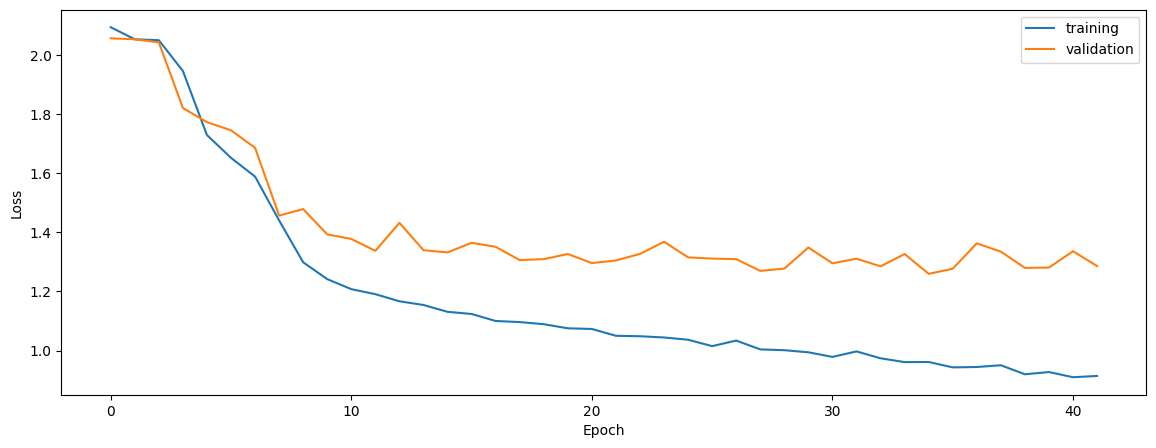

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6352453076620249


0.5175542829320319


0.5810084229450344


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.554010963132209


0.5096381467703753


0.4997710472950873


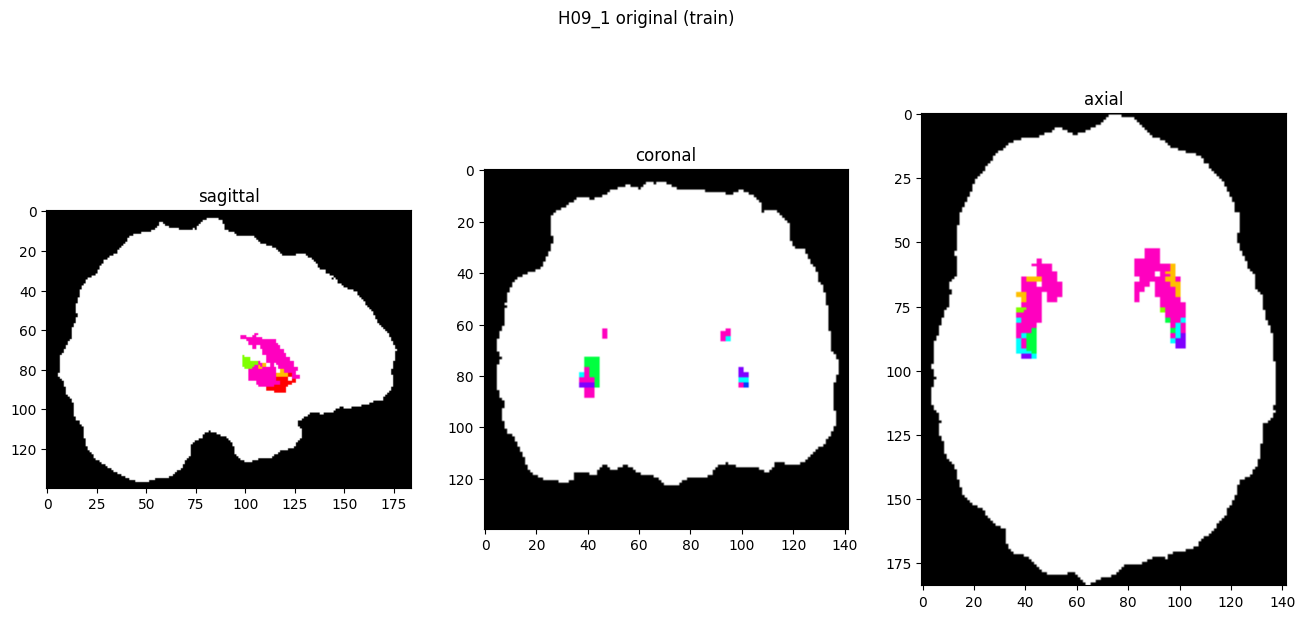

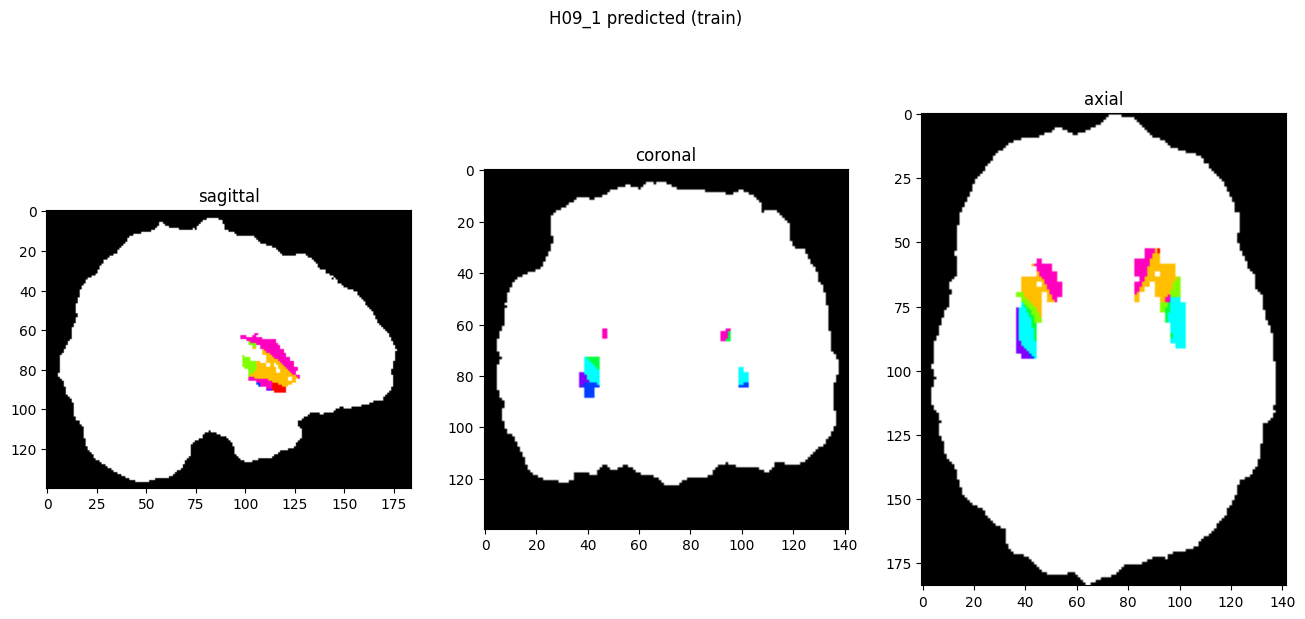

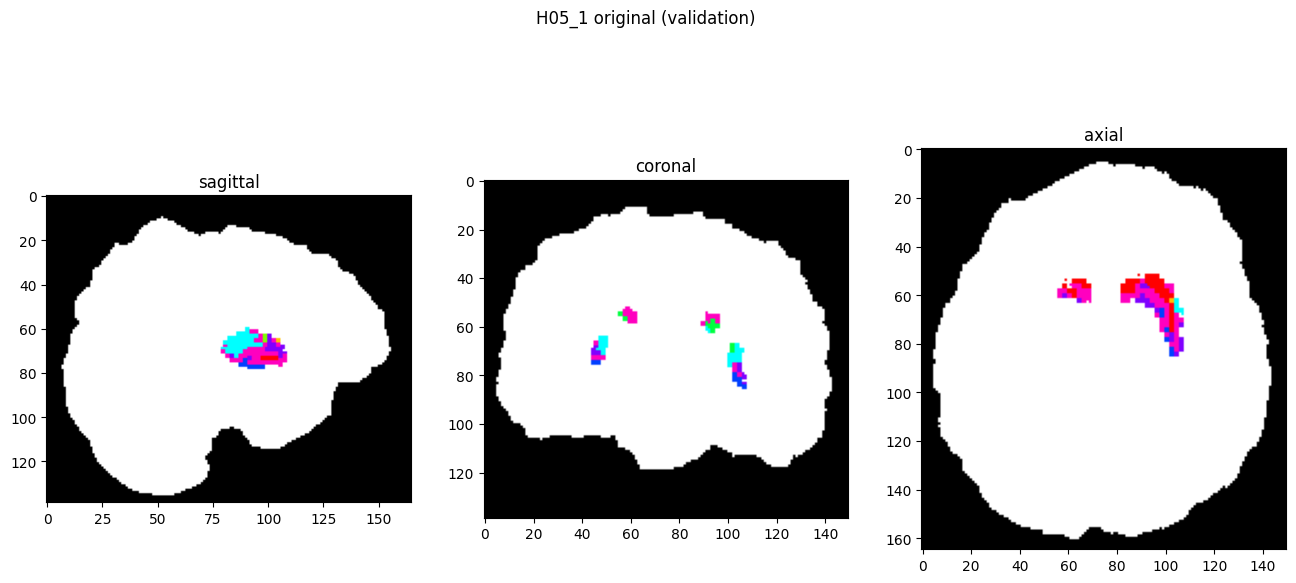

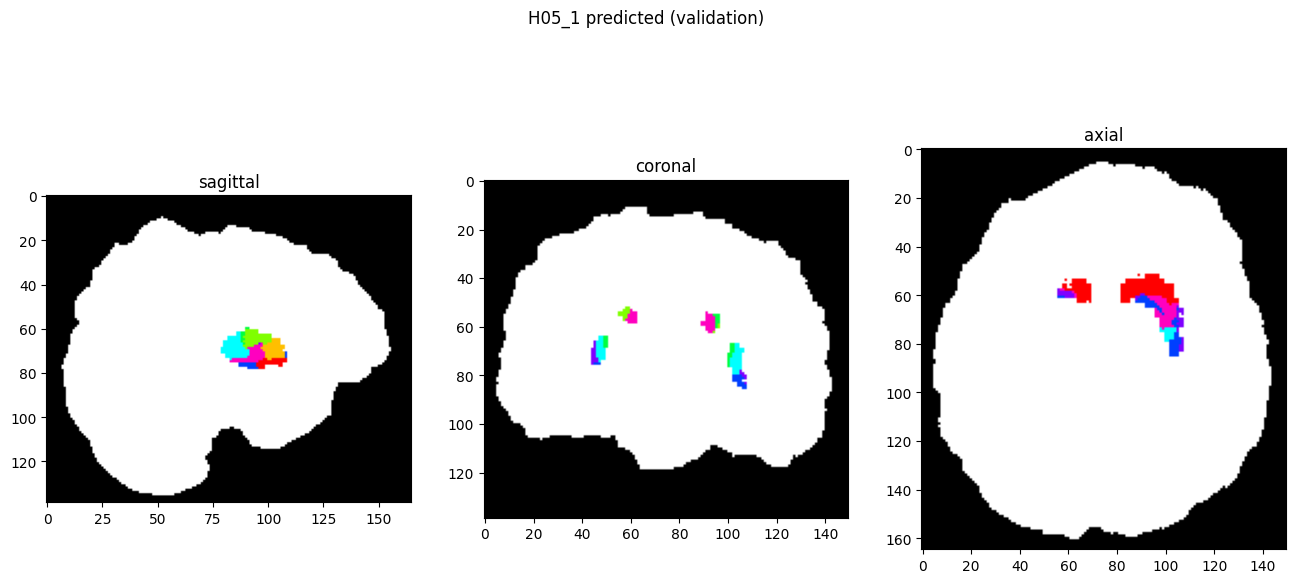

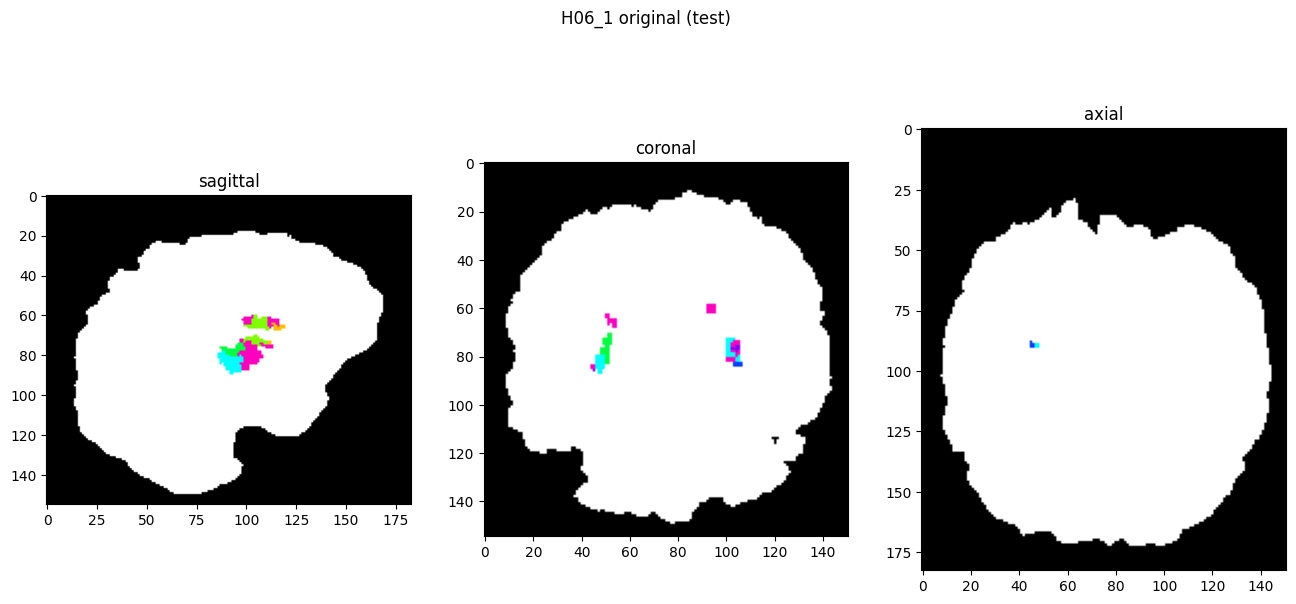

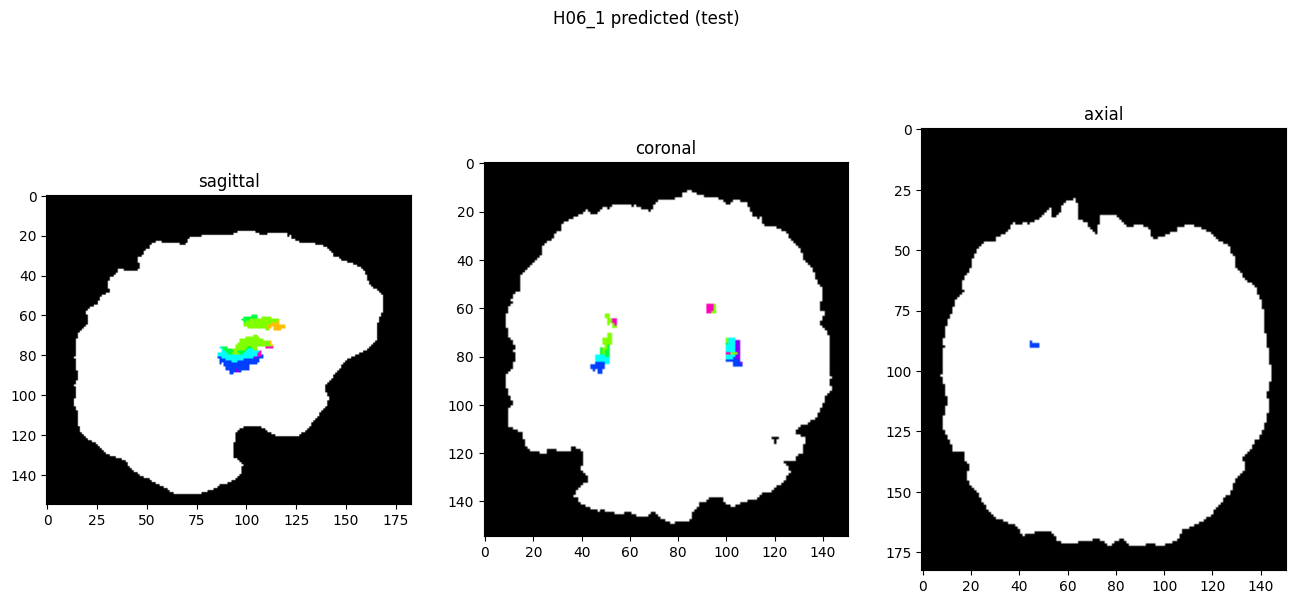

In [9]:
showResults(model, gen, threshold=0)